# Modeling fastText + XGB (XGBoostClassifier) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import Normalizer
from xgboost import XGBClassifier
from joblib import dump

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector
from src.fasttext_vectorizer import FastTextVectorizer

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Repro Setup --- we try to make everything reproducible
import os, random, numpy as np, torch
SEED = 42  #global seed

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision('high')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [3]:
#debug
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 

**a) XGBClassifier with basic preprocessed data**

In [4]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

XGB TPE basic

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnin

Best parameters found by Optuna TPE: {'clf__learning_rate': 0.017585553935896375, 'clf__max_depth': 4, 'clf__gamma': 5.3566996933771085, 'clf__n_estimators': 410, 'clf__colsample_bytree': 0.16117944239441007, 'clf__scale_pos_weight': 15.454637873778212, 'clf__reg_alpha': 1.6775349925361946e-05}
Best F2 score during optimization: 0.707

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


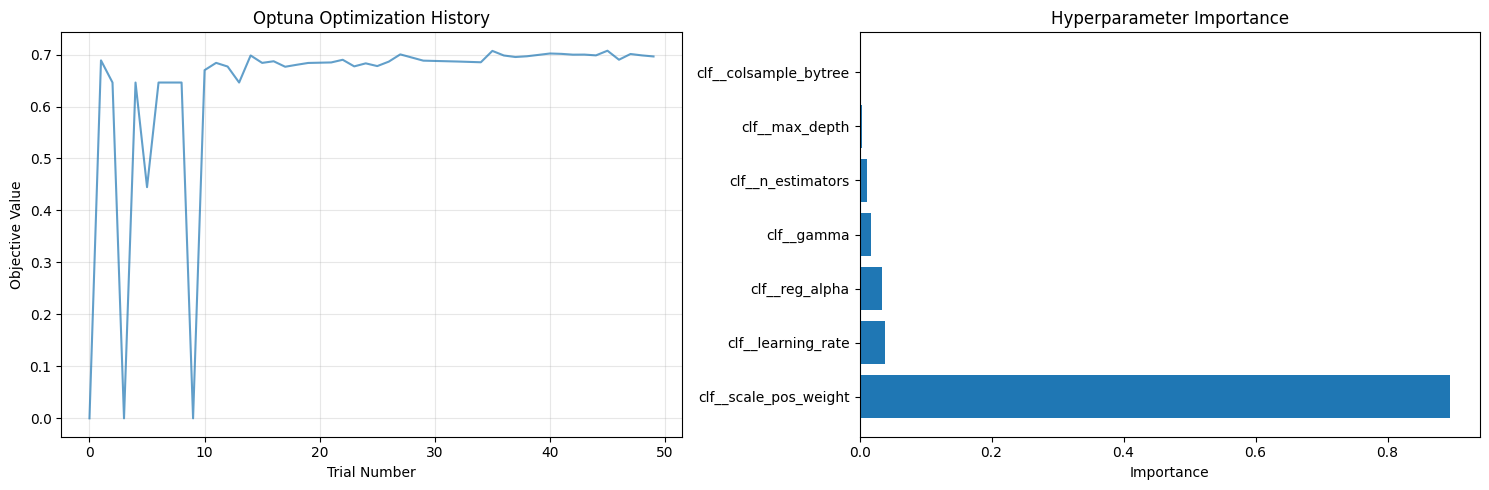


2. Parameter Value Distributions:


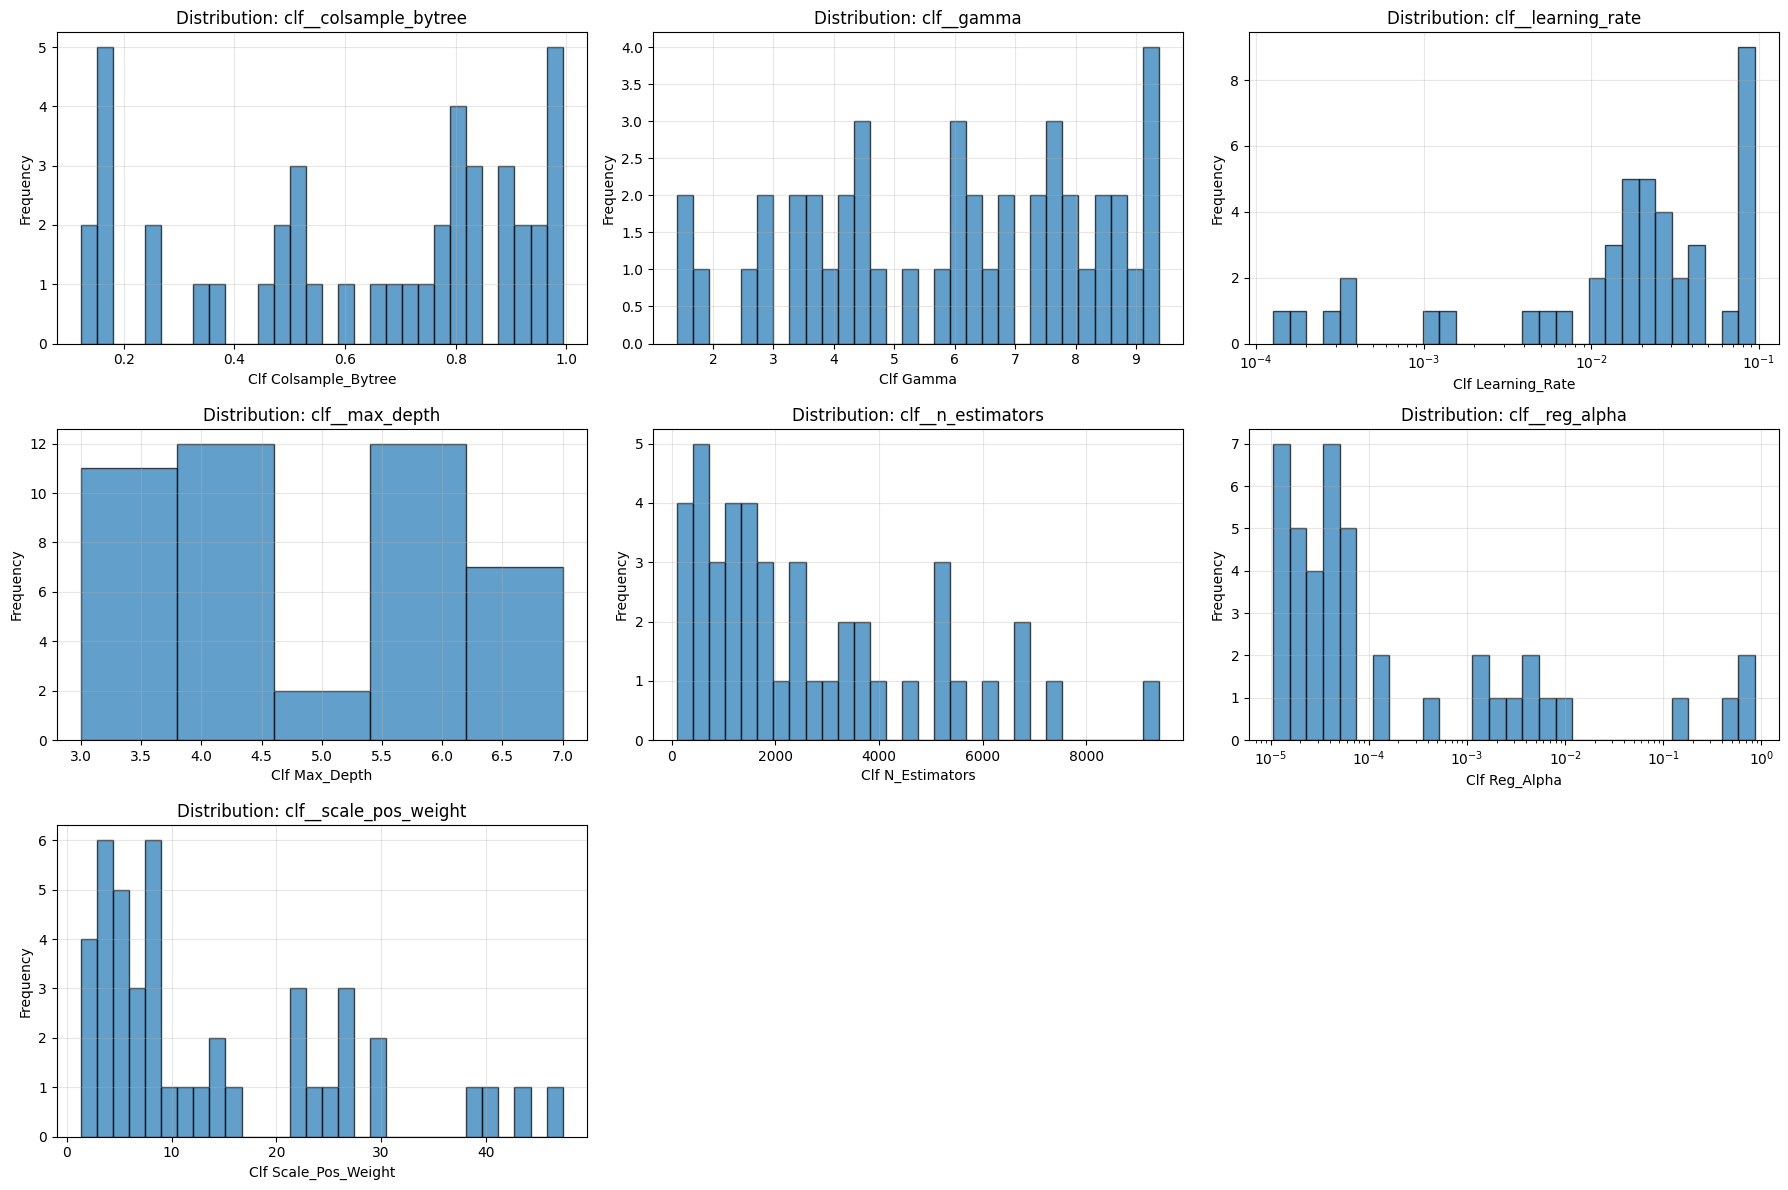


3. Performance vs Individual Parameters:


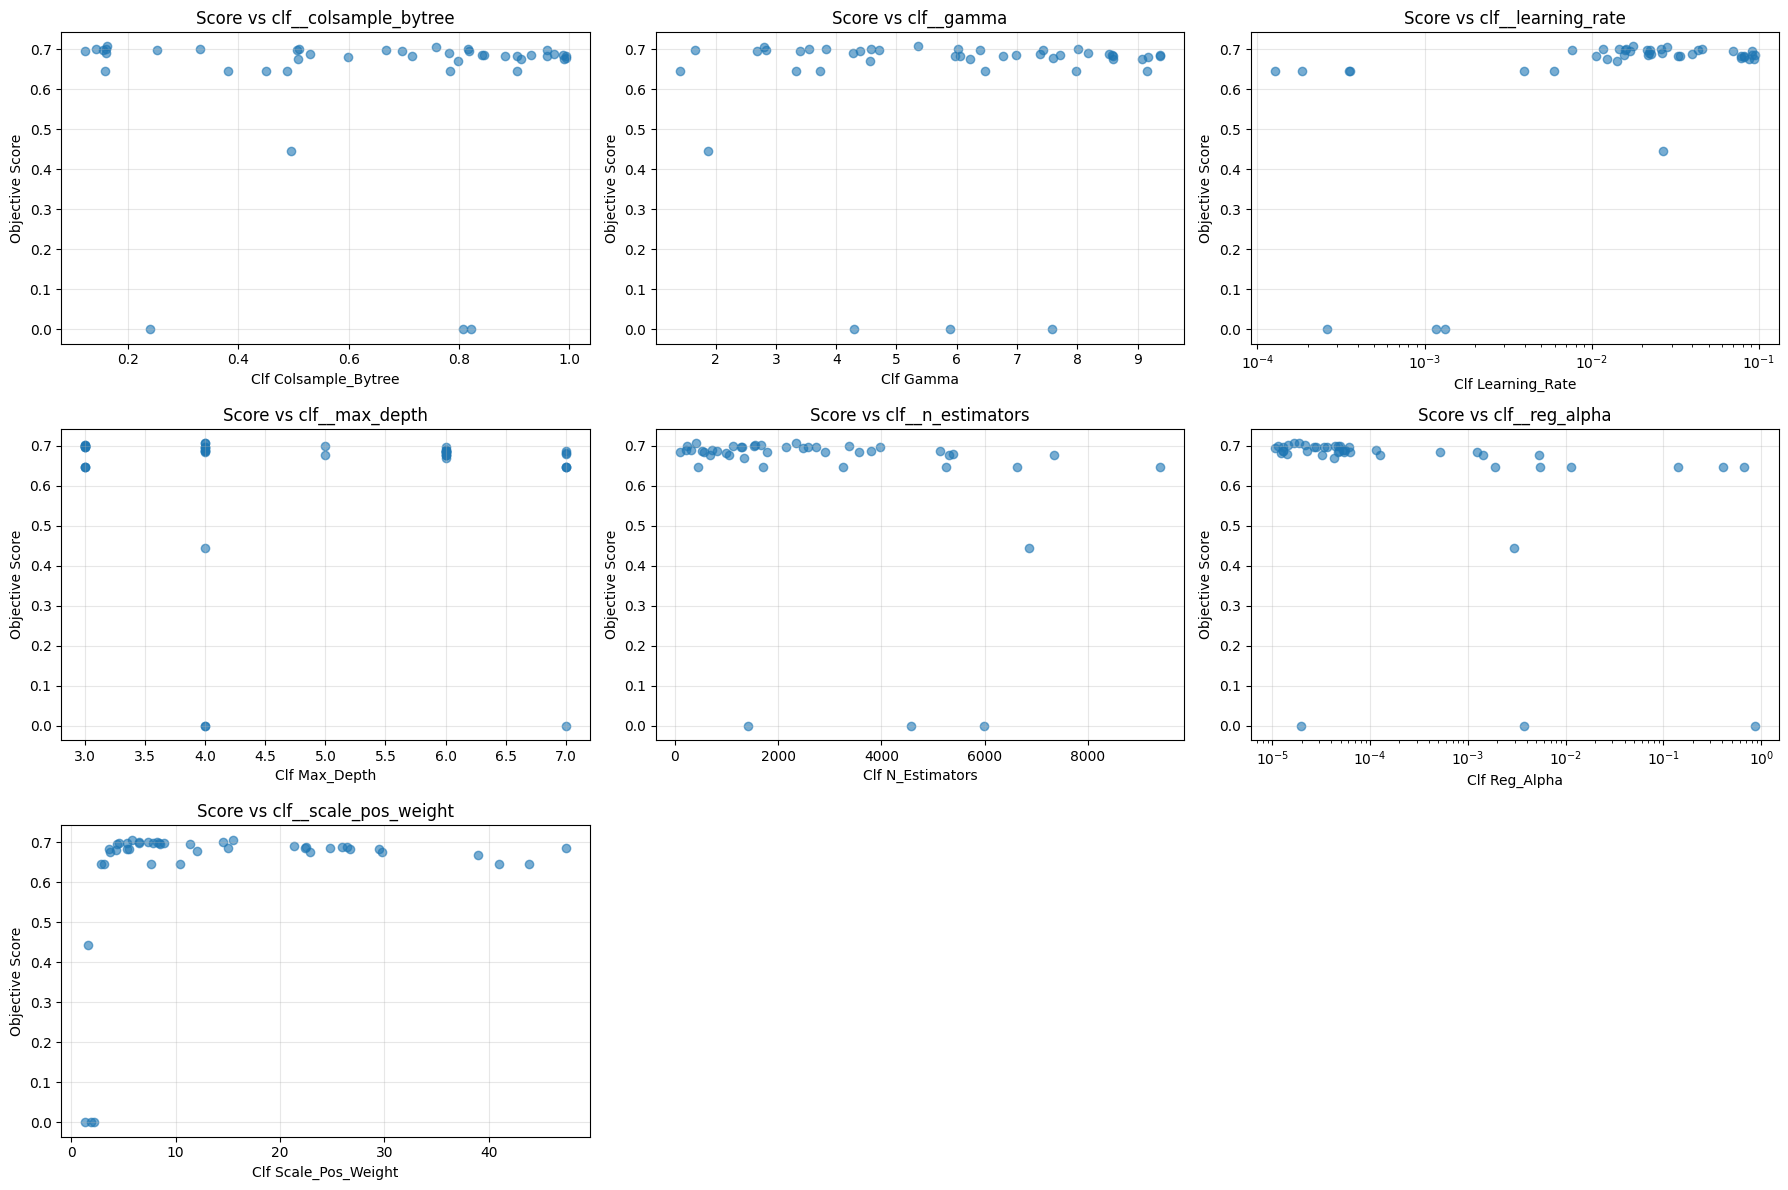


4. Convergence Analysis:


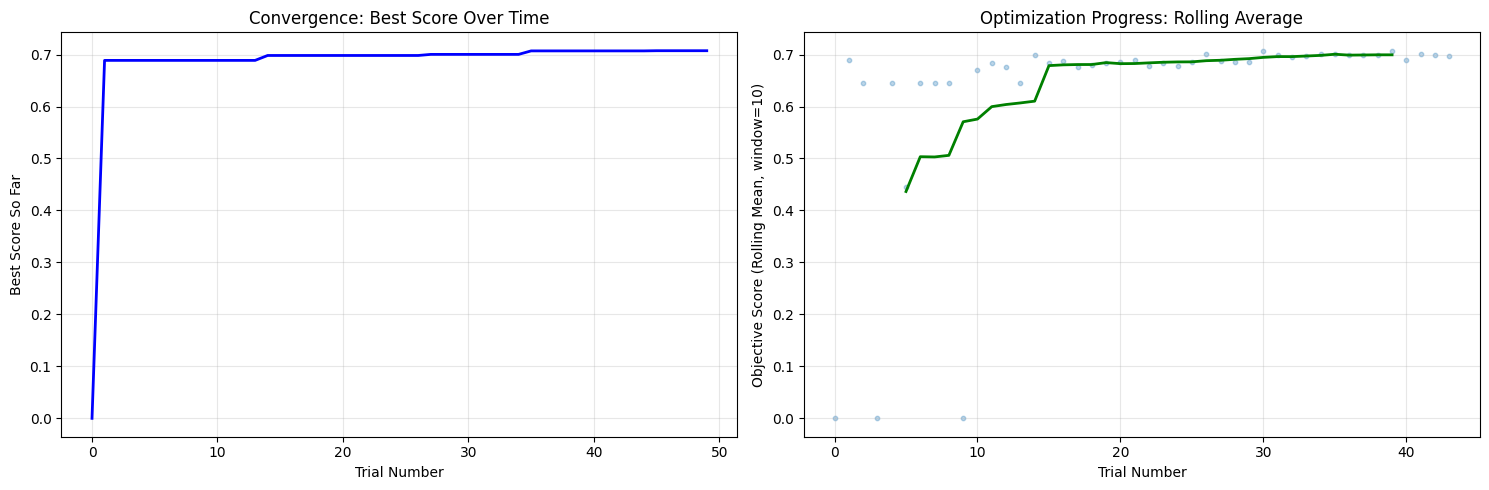


5. Trial Status Overview:


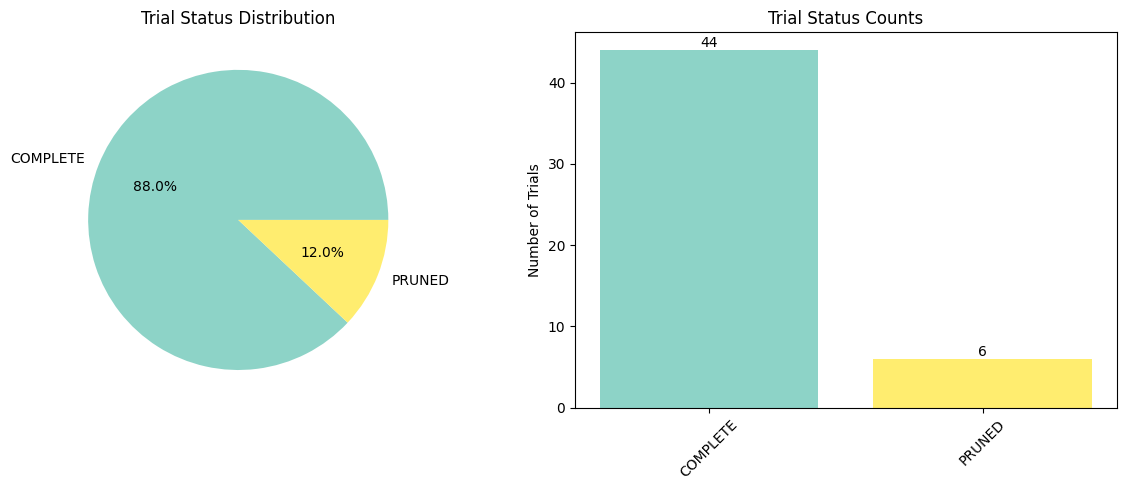


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight
---------------------------------------------------------------------------------------------------------------------------
1    45      0.7073     0.1612       5.3567       0.0176       4            410          0.0000       15.4546     
2    35      0.7070     0.7587       2.7995       0.0281       4            2350         0.0000       5.7886      
3    40      0.7020     0.3305       3.5564       0.0455       3            1560         0.0000       6.5020      
4    41      0.7013     0.1600       3.8265       0.0259       3            1670         0.0000       8.2489      
5    47      0.7010     0.5102       4.5732       0.0146       3            240          0.0000       7.3352      
6    27      0.7003     0.8160       8.0078       0.0160       5            3380         0.0000       14.5423     
7    43      0.6999     0.1419       6

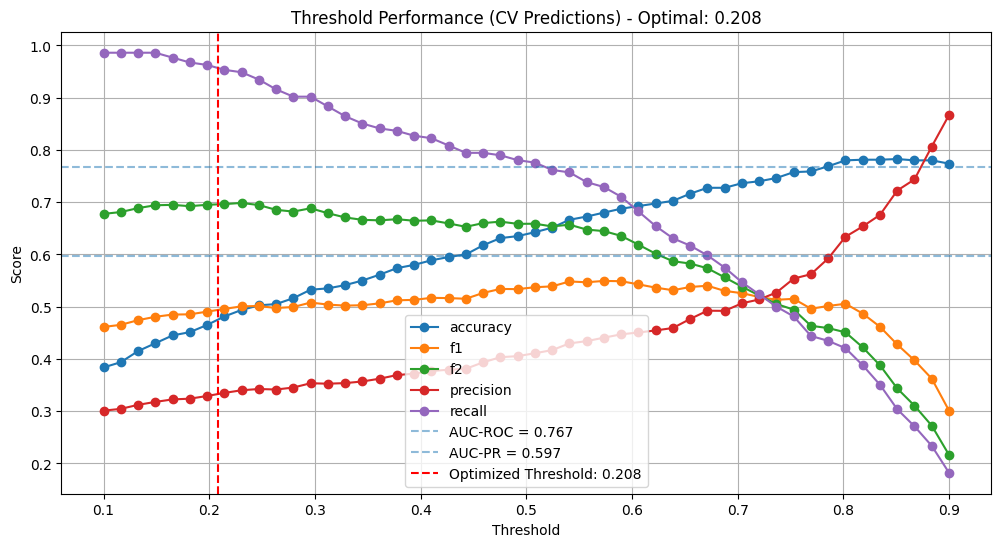

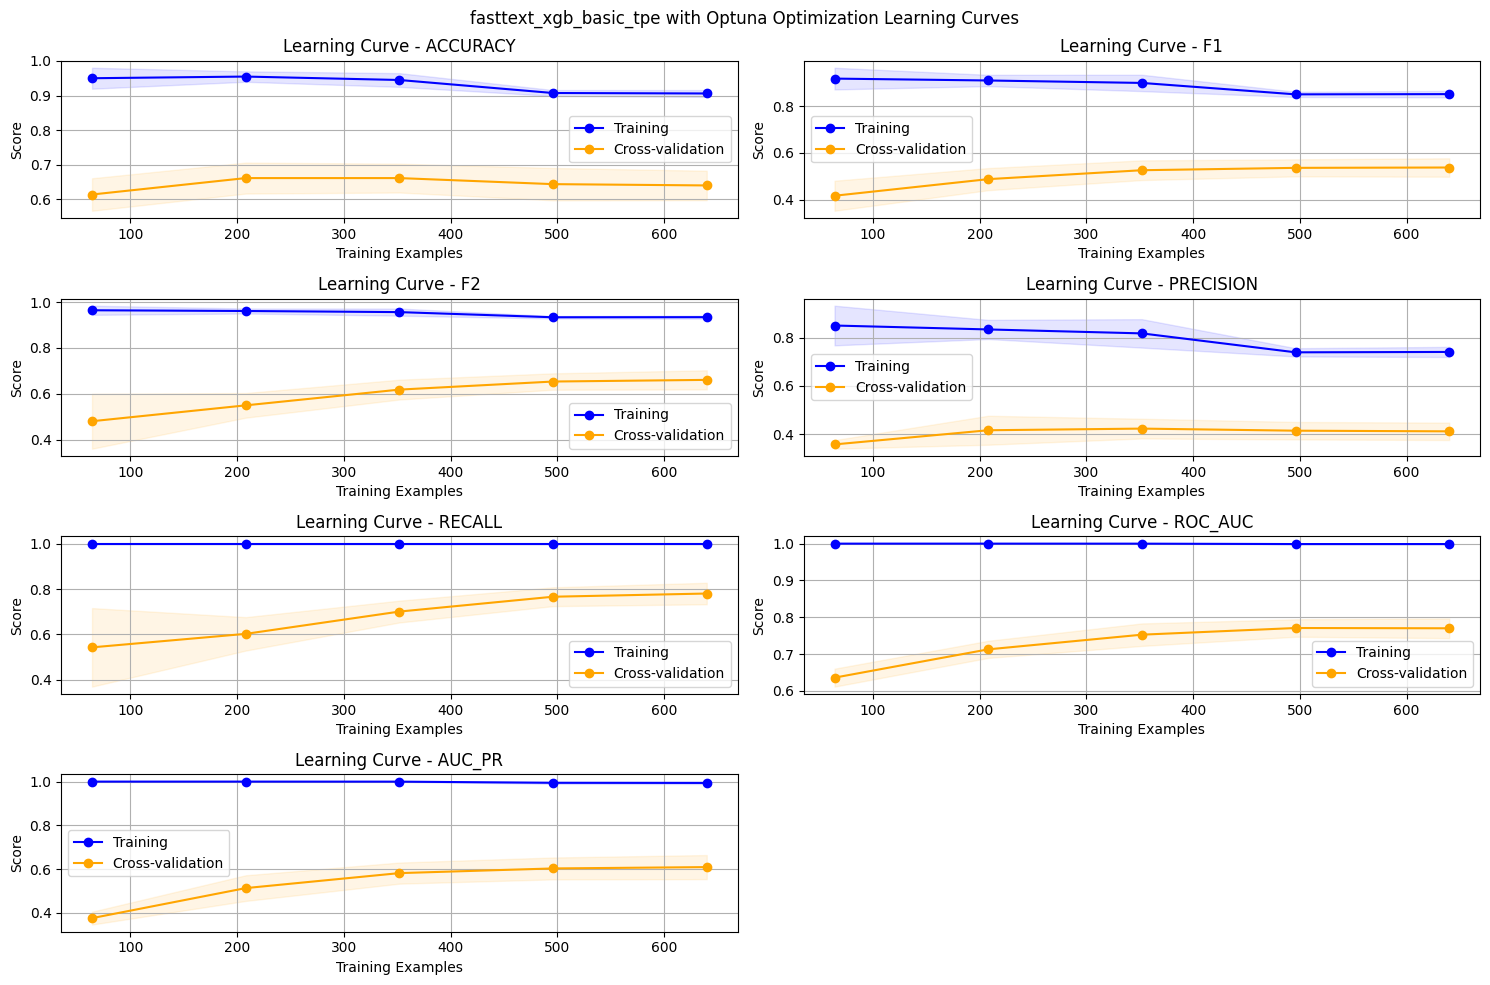


Final Threshold: 0.21

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.20      0.33       146
           1       0.30      0.94      0.46        54

    accuracy                           0.40       200
   macro avg       0.60      0.57      0.39       200
weighted avg       0.74      0.40      0.36       200

Additional Metrics:
Accuracy   0.400
F2-score   0.664
AUC-ROC    0.718
AUC-PR     0.548



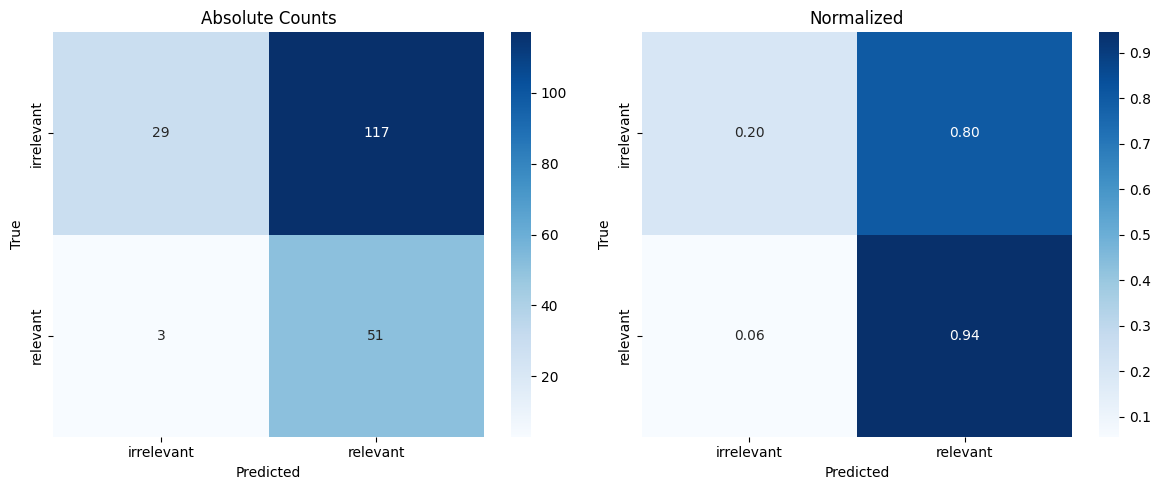

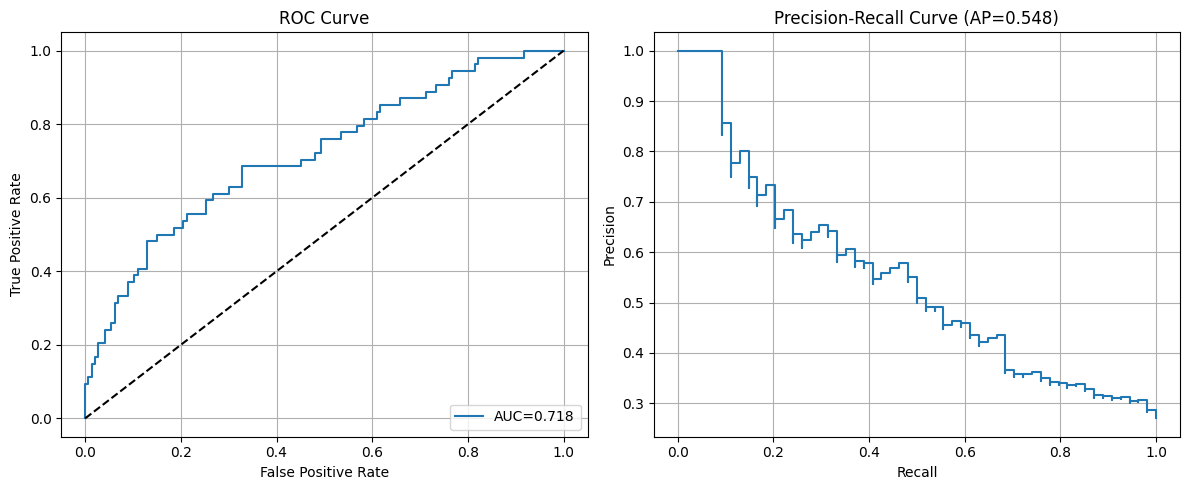


Model saved as model_fasttext_xgb_basic_tpe.joblib


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)


# Define a pipeline with fastText vectorization
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")
pipeline_fasttext_xgb = Pipeline([
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__learning_rate":    lambda t: t.suggest_float("clf__learning_rate", 1e-4, 1e-1, log=True),   #  Reusens et al. ranges; log-scale matches multiplicative sensitivity of LR
    "clf__max_depth":        lambda t: t.suggest_int("clf__max_depth", 3, 7),                         #  Reusens et al.: shallow trees fit high-dim sparse TF-IDF features
    "clf__gamma":            lambda t: t.suggest_float("clf__gamma", 1.0, 10.0),                      #  Reusens et al.: minimum loss reduction to make a split (regularizes splits)
    "clf__n_estimators":     lambda t: t.suggest_int("clf__n_estimators", 10, 10000, step=10),        #  Reusens et al.: upper bound; Early Stopping in  objective picks best iteration
    "clf__colsample_bytree": lambda t: t.suggest_float("clf__colsample_bytree", 0.1, 1.0),            #  Reusens et al.: feature subsampling per tree; helps generalization with many sparse features
    "clf__scale_pos_weight": lambda t: t.suggest_float("clf__scale_pos_weight", 1.0, 50.0, log=True), #  XGBoost-native class balancing; typical anchor is sum(neg)/sum(pos). Search narrowly (±~3x, log) around data-driven ratio.
    "clf__reg_alpha":        lambda t: t.suggest_float("clf__reg_alpha", 1e-5, 1.0, log=True)        # useful L1 on leaf weights: promotes conservatism/sparsity in tree outputs; kept narrow & log to avoid bloating search    
}

model_name = "fasttext_xgb_basic_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_fasttext_xgb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "xgboost",
    n_trials=50,  # Intelligent search with early stopping
    n_startup_trials=10,
    n_warmup_steps=1, #first trial not pruned
    intervall_steps=1, #pruning possible for every trial
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

XGB GridSearch Basic

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__scale_pos_weight': 15.5, 'clf__colsample_bytree': 0.3, 'clf__n_estimators': 300, 'clf__learning_rate': 0.018, 'clf__max_depth': 4, 'clf__gamma': 5.4, 'clf__reg_alpha': 0.0}
Best F2 score during optimization: 0.670

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


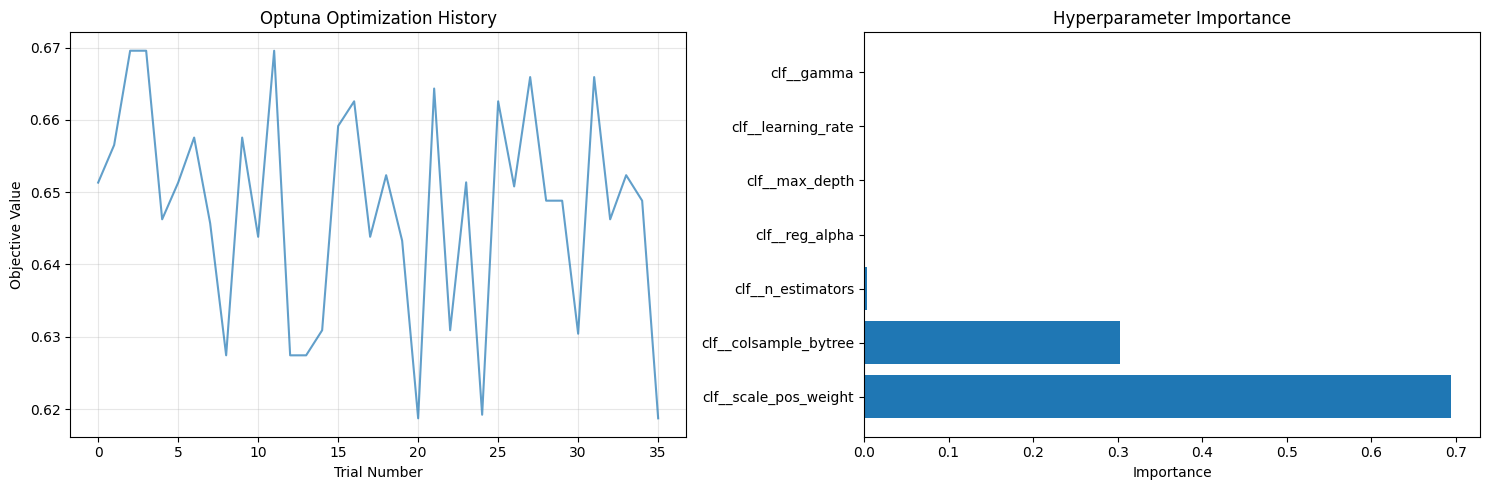


2. Parameter Value Distributions:


c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code\src\optuna_visualizations.py:208: RuntimeWarning: divide by zero encountered in log10
  np.log10(min(numeric_values)),
c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code\src\optuna_visualizations.py:209: RuntimeWarning: divide by zero encountered in log10
  np.log10(max(numeric_values)),
c:\Users\tdoro\miniconda3\Lib\site-packages\numpy\core\function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start


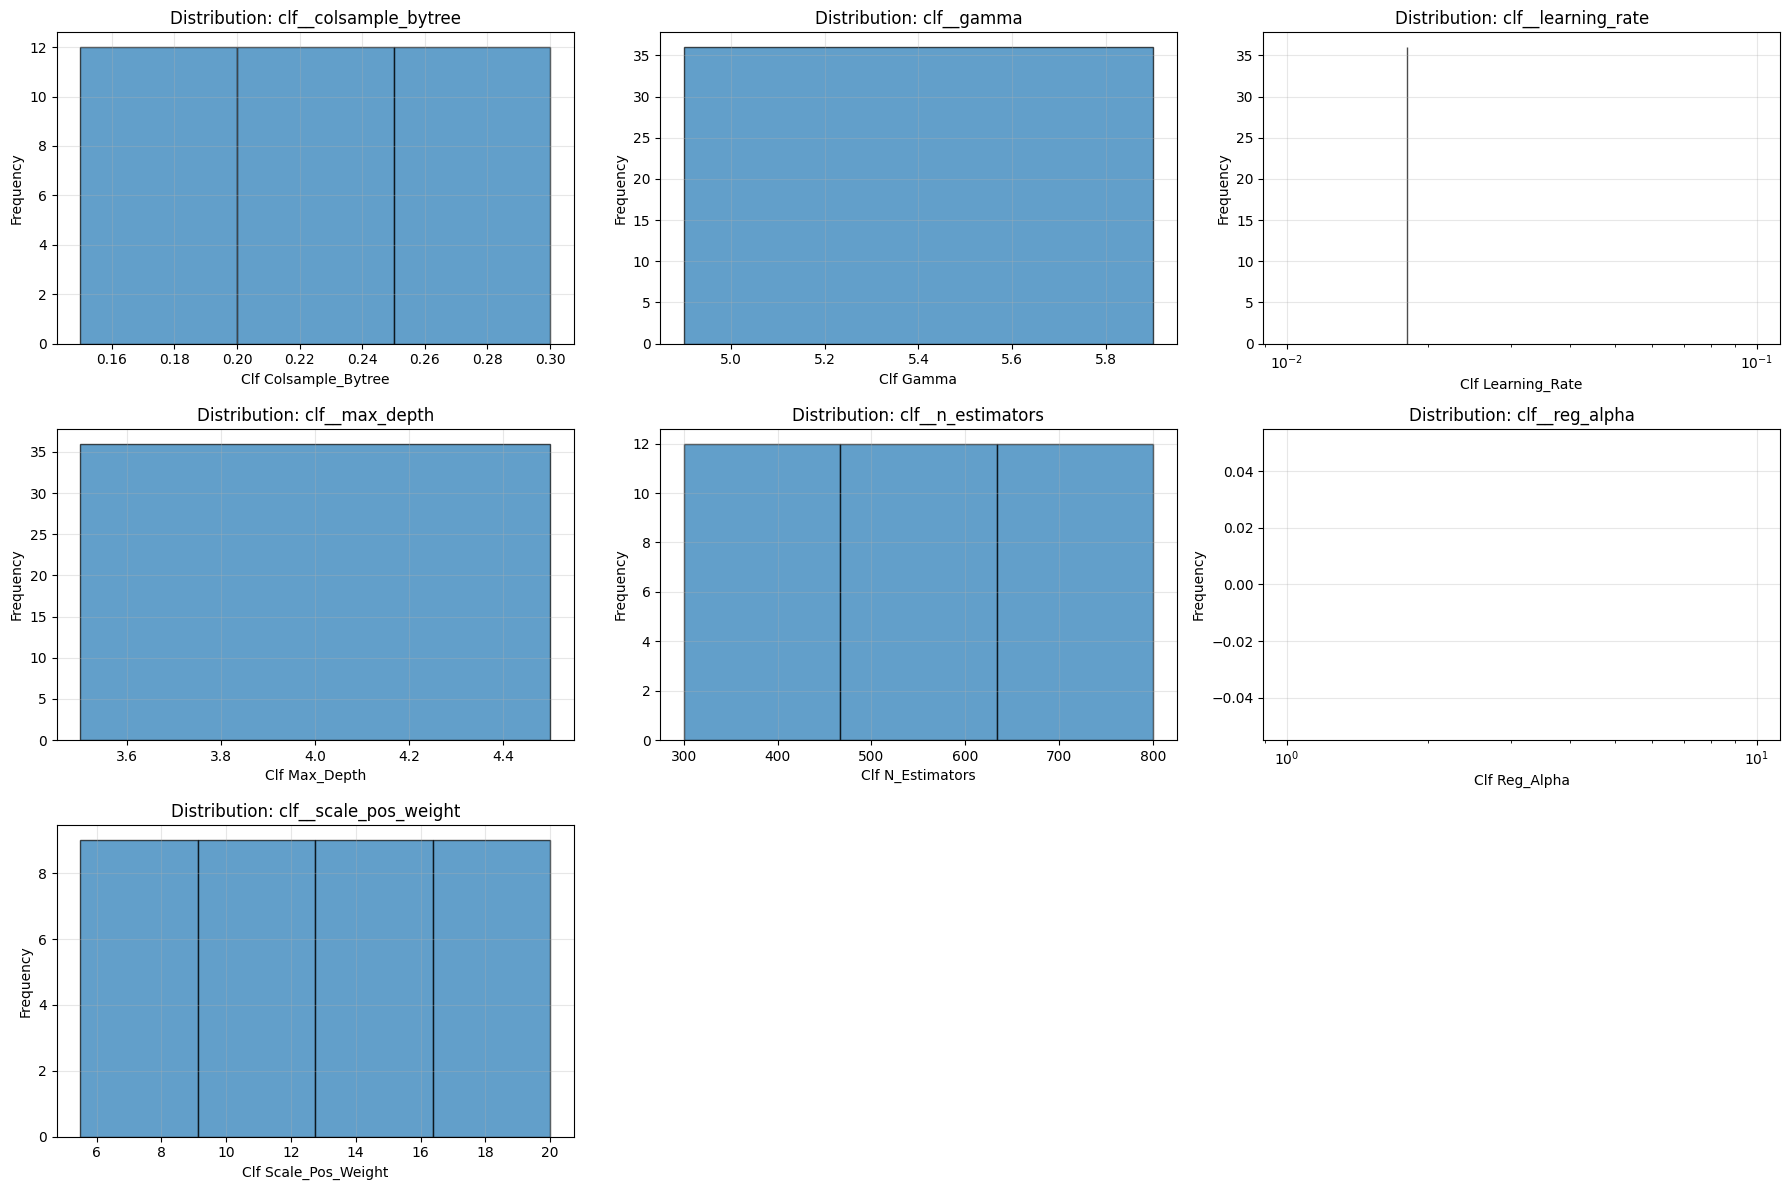


3. Performance vs Individual Parameters:


c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code\src\optuna_visualizations.py:314: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_xscale('log')


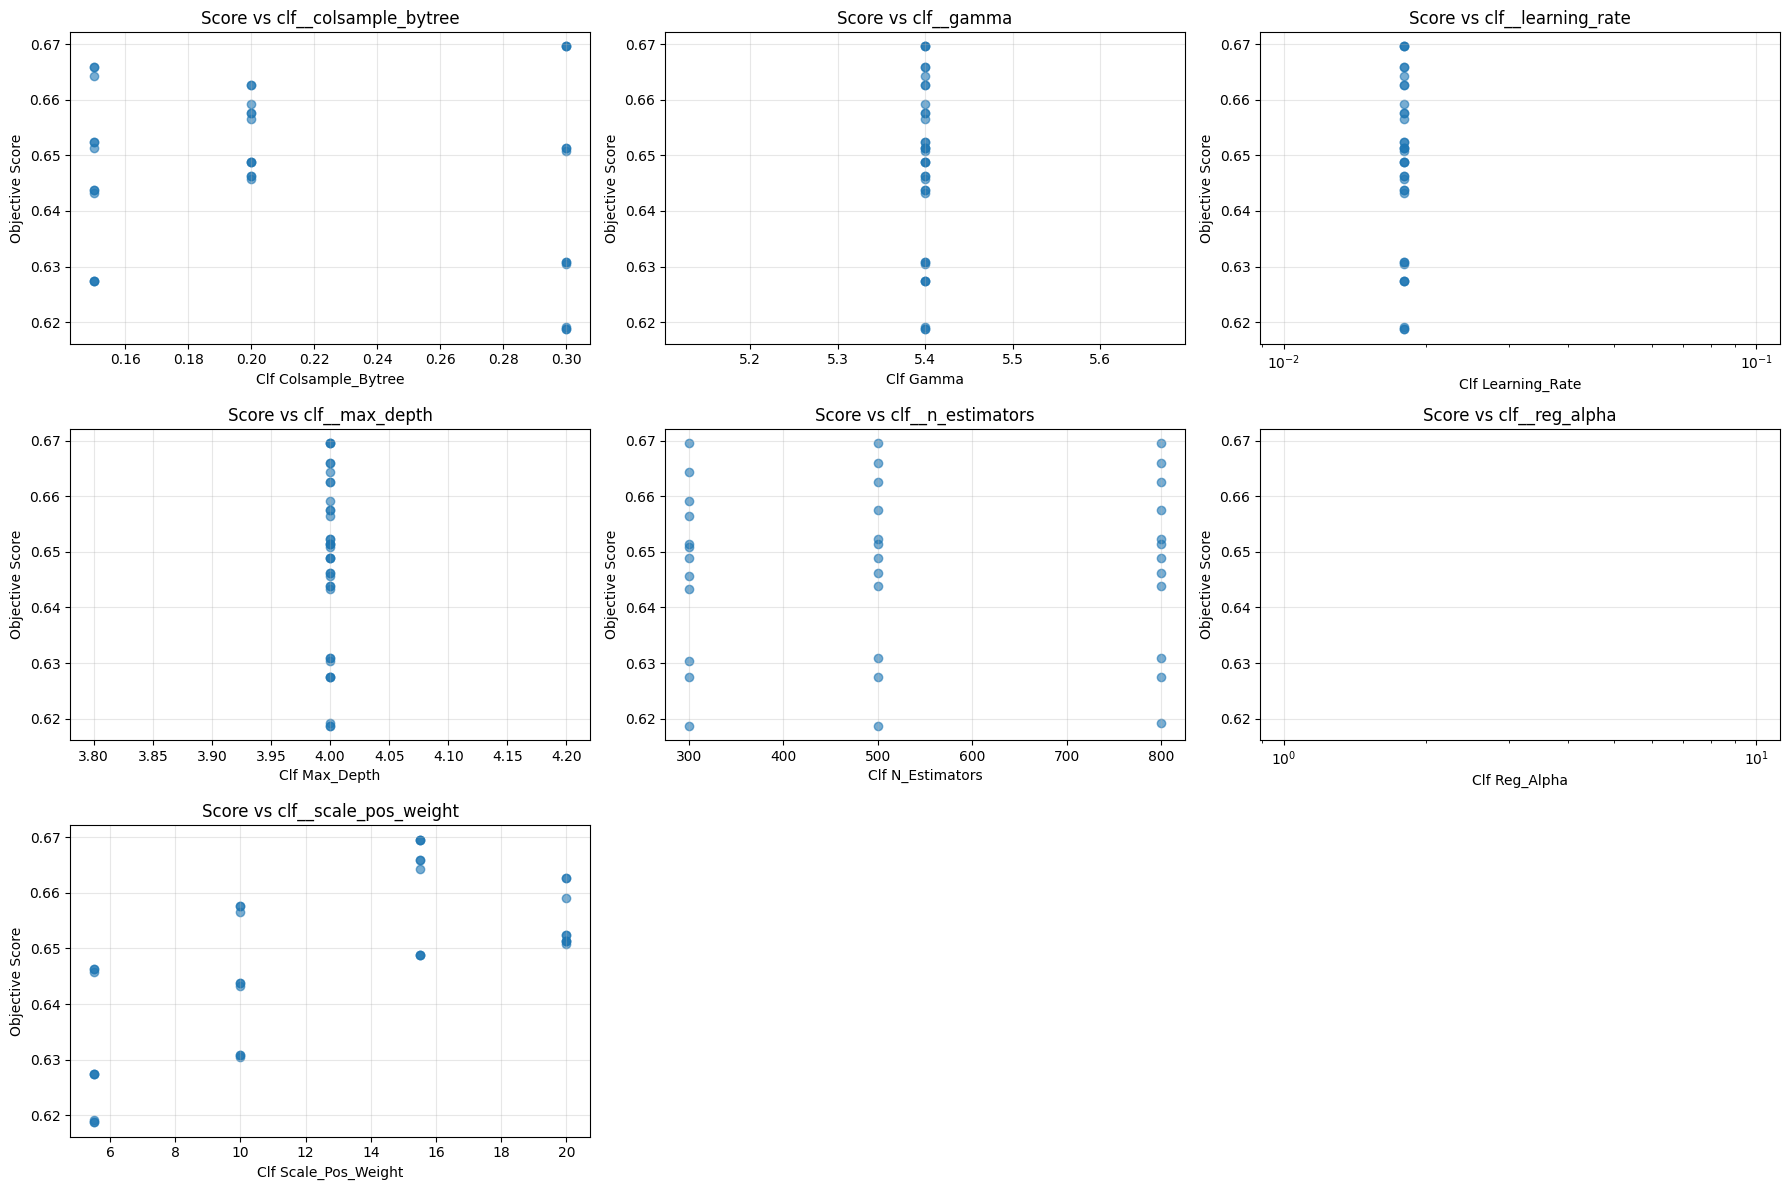


4. Convergence Analysis:


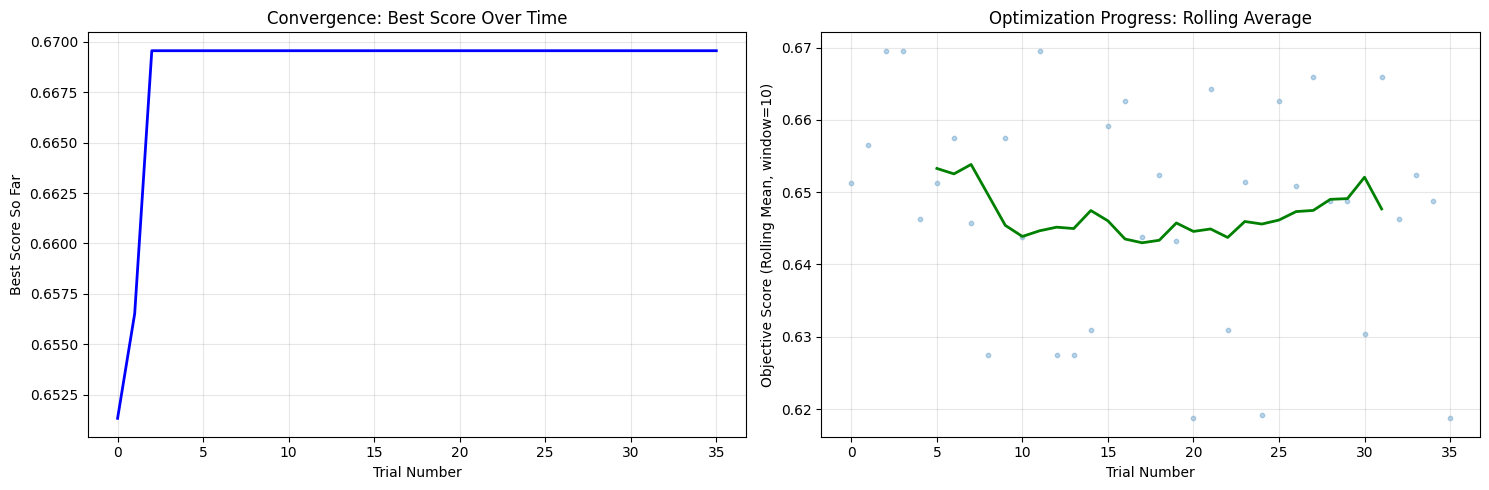


5. Trial Status Overview:


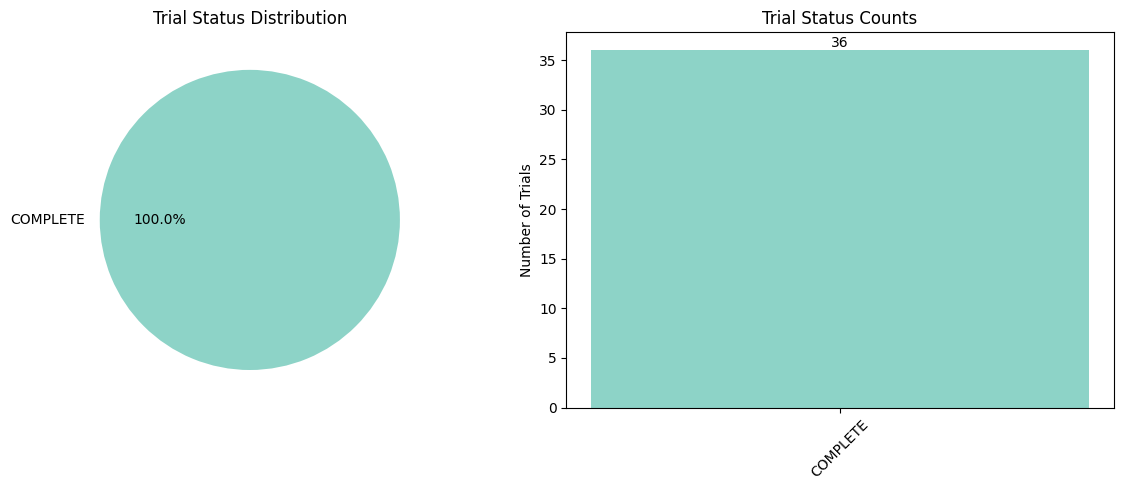


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight
---------------------------------------------------------------------------------------------------------------------------
1    2       0.6696     0.3000       5.4000       0.0180       4            300          0.0000       15.5000     
2    3       0.6696     0.3000       5.4000       0.0180       4            500          0.0000       15.5000     
3    11      0.6696     0.3000       5.4000       0.0180       4            800          0.0000       15.5000     
4    27      0.6659     0.1500       5.4000       0.0180       4            800          0.0000       15.5000     
5    31      0.6659     0.1500       5.4000       0.0180       4            500          0.0000       15.5000     
6    21      0.6643     0.1500       5.4000       0.0180       4            300          0.0000       15.5000     
7    16      0.6626     0.2000       5

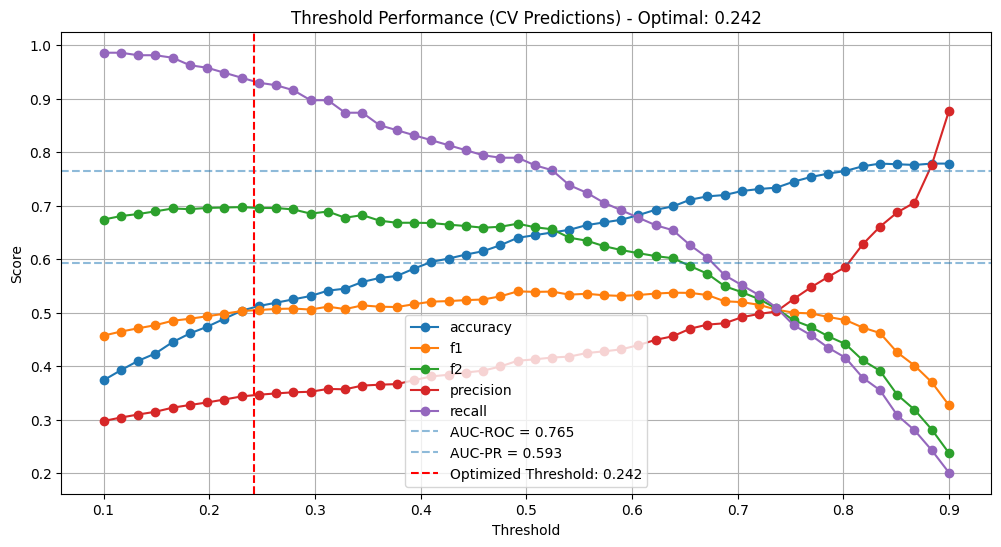

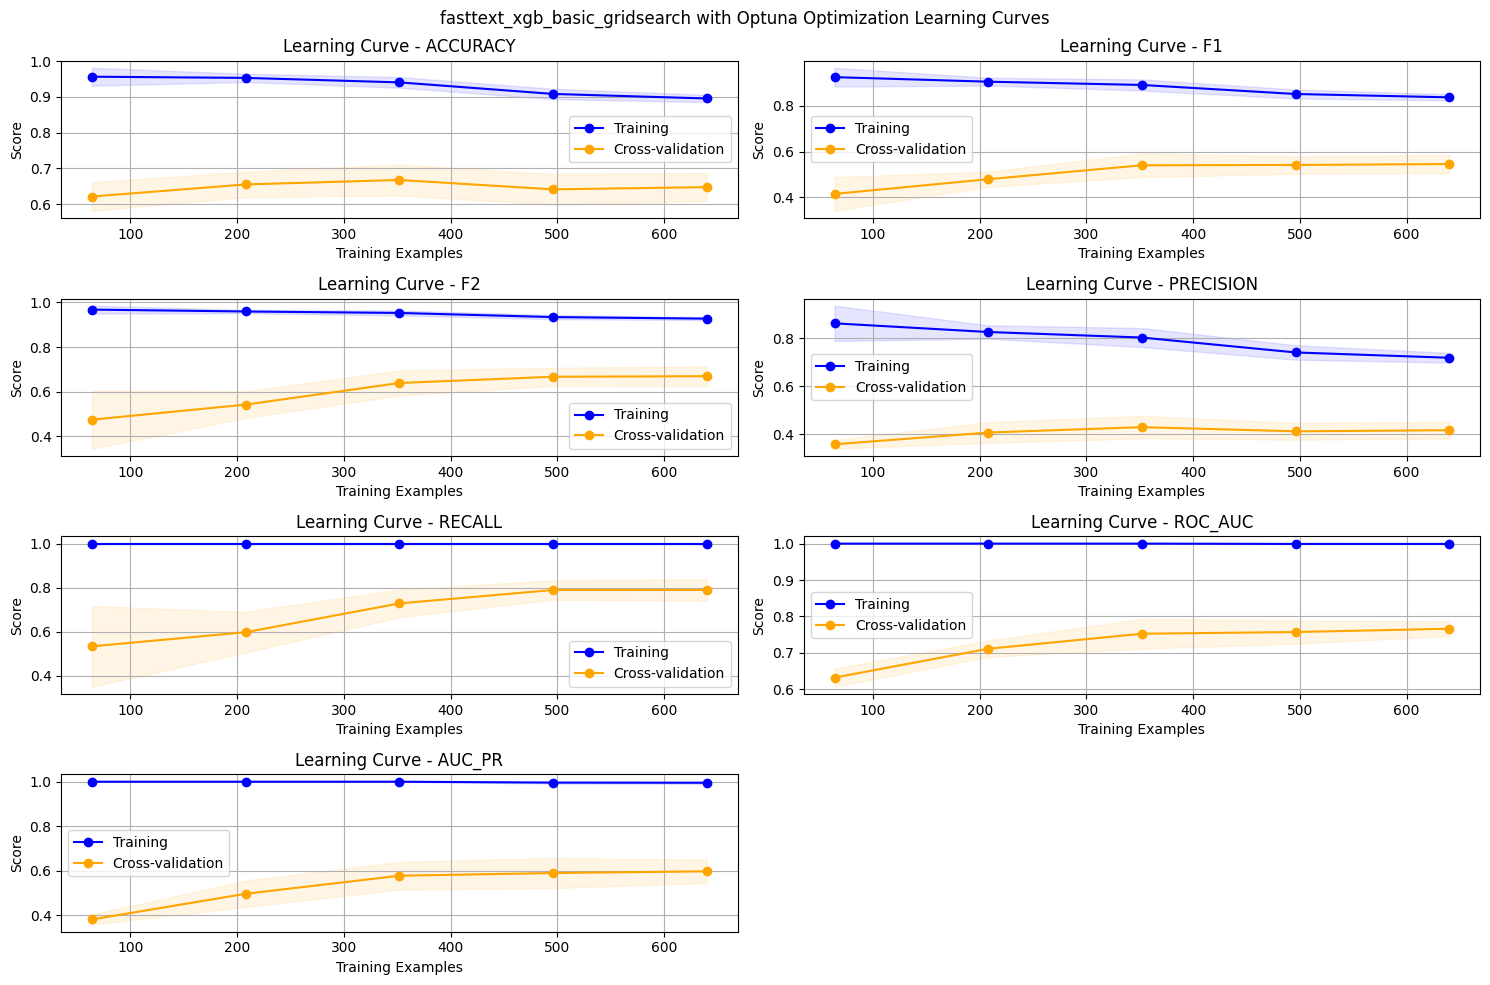


Final Threshold: 0.24

Test Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.24      0.38       146
           1       0.31      0.94      0.47        54

    accuracy                           0.43       200
   macro avg       0.62      0.59      0.43       200
weighted avg       0.76      0.43      0.41       200

Additional Metrics:
Accuracy   0.430
F2-score   0.675
AUC-ROC    0.724
AUC-PR     0.554



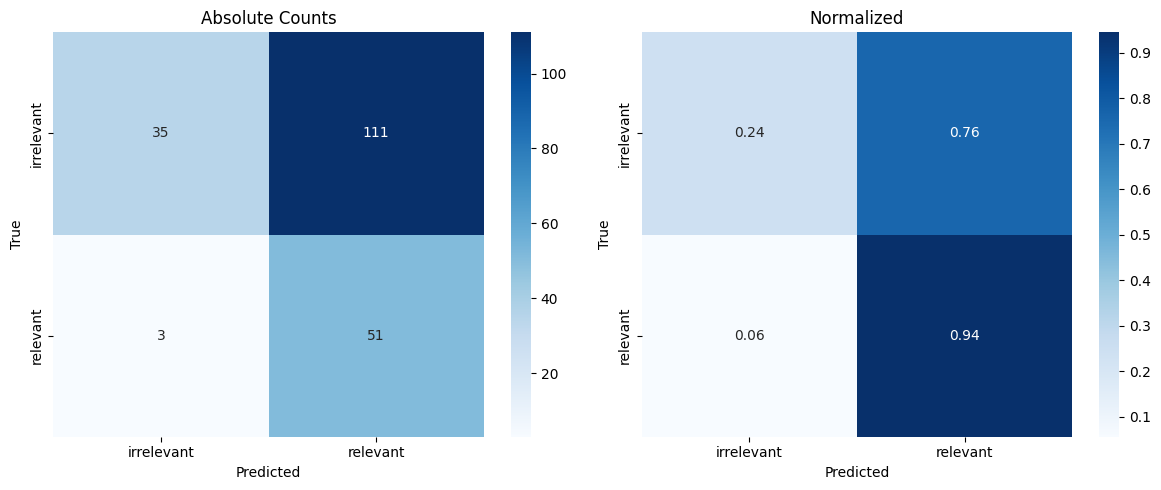

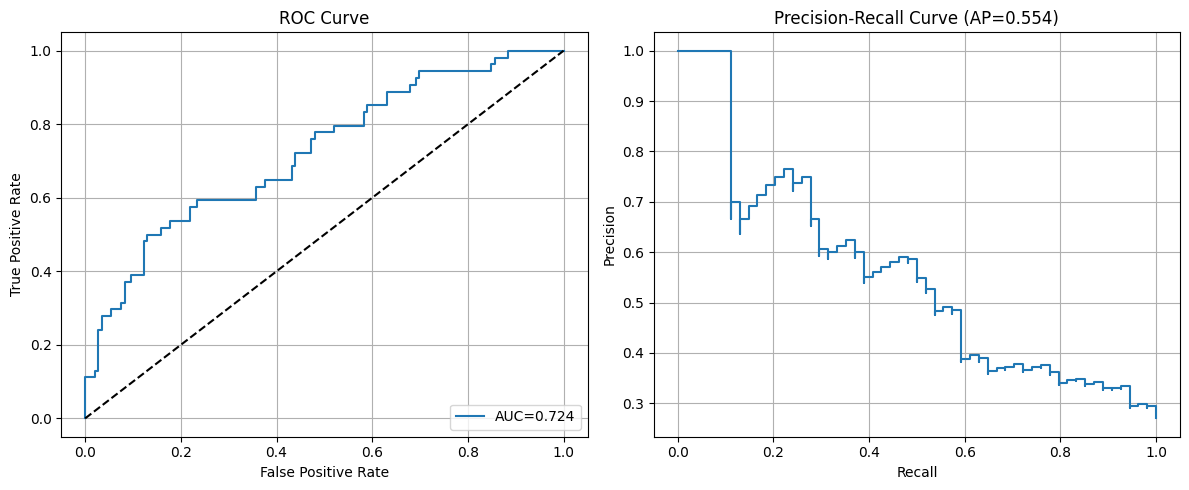


Model saved as model_fasttext_xgb_basic_gridsearch.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)


# Define a pipeline with fastText vectorization
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")
pipeline_fasttext_xgb = Pipeline([
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearch
param_grid = {
    # Top 3 most important params (based on Optuna importance & best trial proximity)
    "clf__scale_pos_weight": [5.5, 10.0, 15.5, 20.0],    # best ≈15.5; vary around ±~5
    "clf__colsample_bytree": [0.15, 0.20, 0.30],         # best ≈0.16; scouts up
    "clf__n_estimators": [300, 500, 800],                # best ≈410; probe lower/higher

    # Fix remaining params at Optuna-best
    "clf__learning_rate": [0.018],                       # best ≈0.0176
    "clf__max_depth": [4],                               # best 4
    "clf__gamma": [5.4],                                 # best ≈5.36
    "clf__reg_alpha": [0.0],                             # best ~1.7e-05 ≈ 0
}


model_name = "fasttext_xgb_basic_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_fasttext_xgb,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

**b) XGBClassifier based on advanced preprocessed data**

In [7]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

XGB TPE advanced

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnin

Best parameters found by Optuna TPE: {'clf__learning_rate': 0.07757695017485589, 'clf__max_depth': 4, 'clf__gamma': 1.5241150623056652, 'clf__n_estimators': 6220, 'clf__colsample_bytree': 0.3751684847607606, 'clf__scale_pos_weight': 18.296634423256588, 'clf__reg_alpha': 2.957101699854769, 'phrases__enable': True, 'phrases__min_count': 32, 'phrases__threshold': 5.1711692674664205}
Best F2 score during optimization: 0.752

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


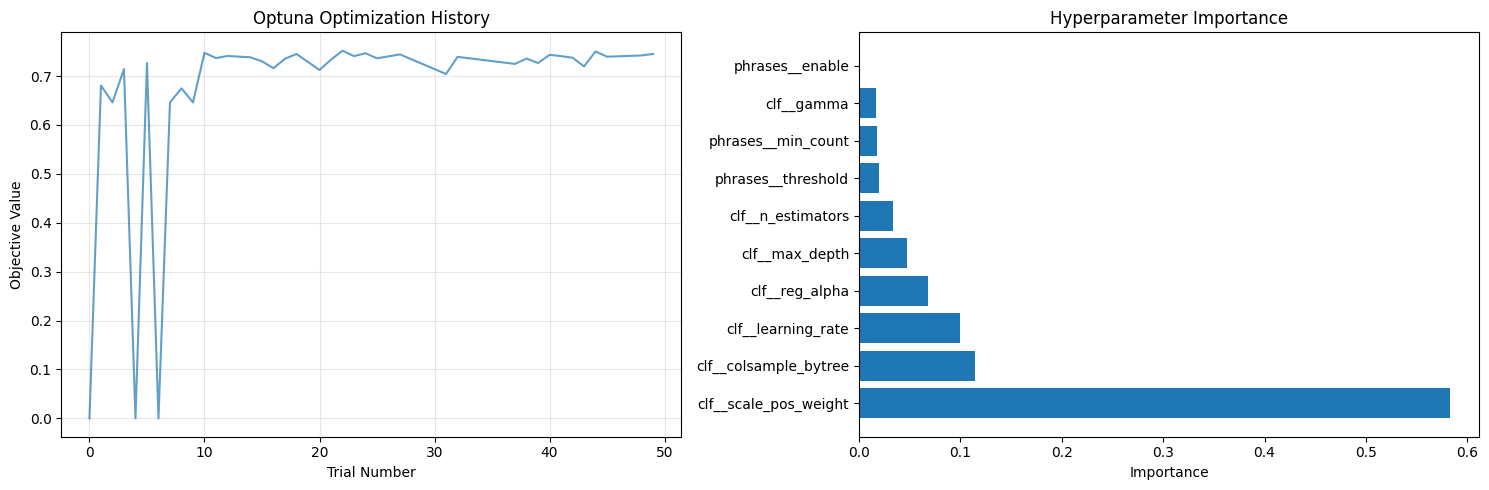


2. Parameter Value Distributions:


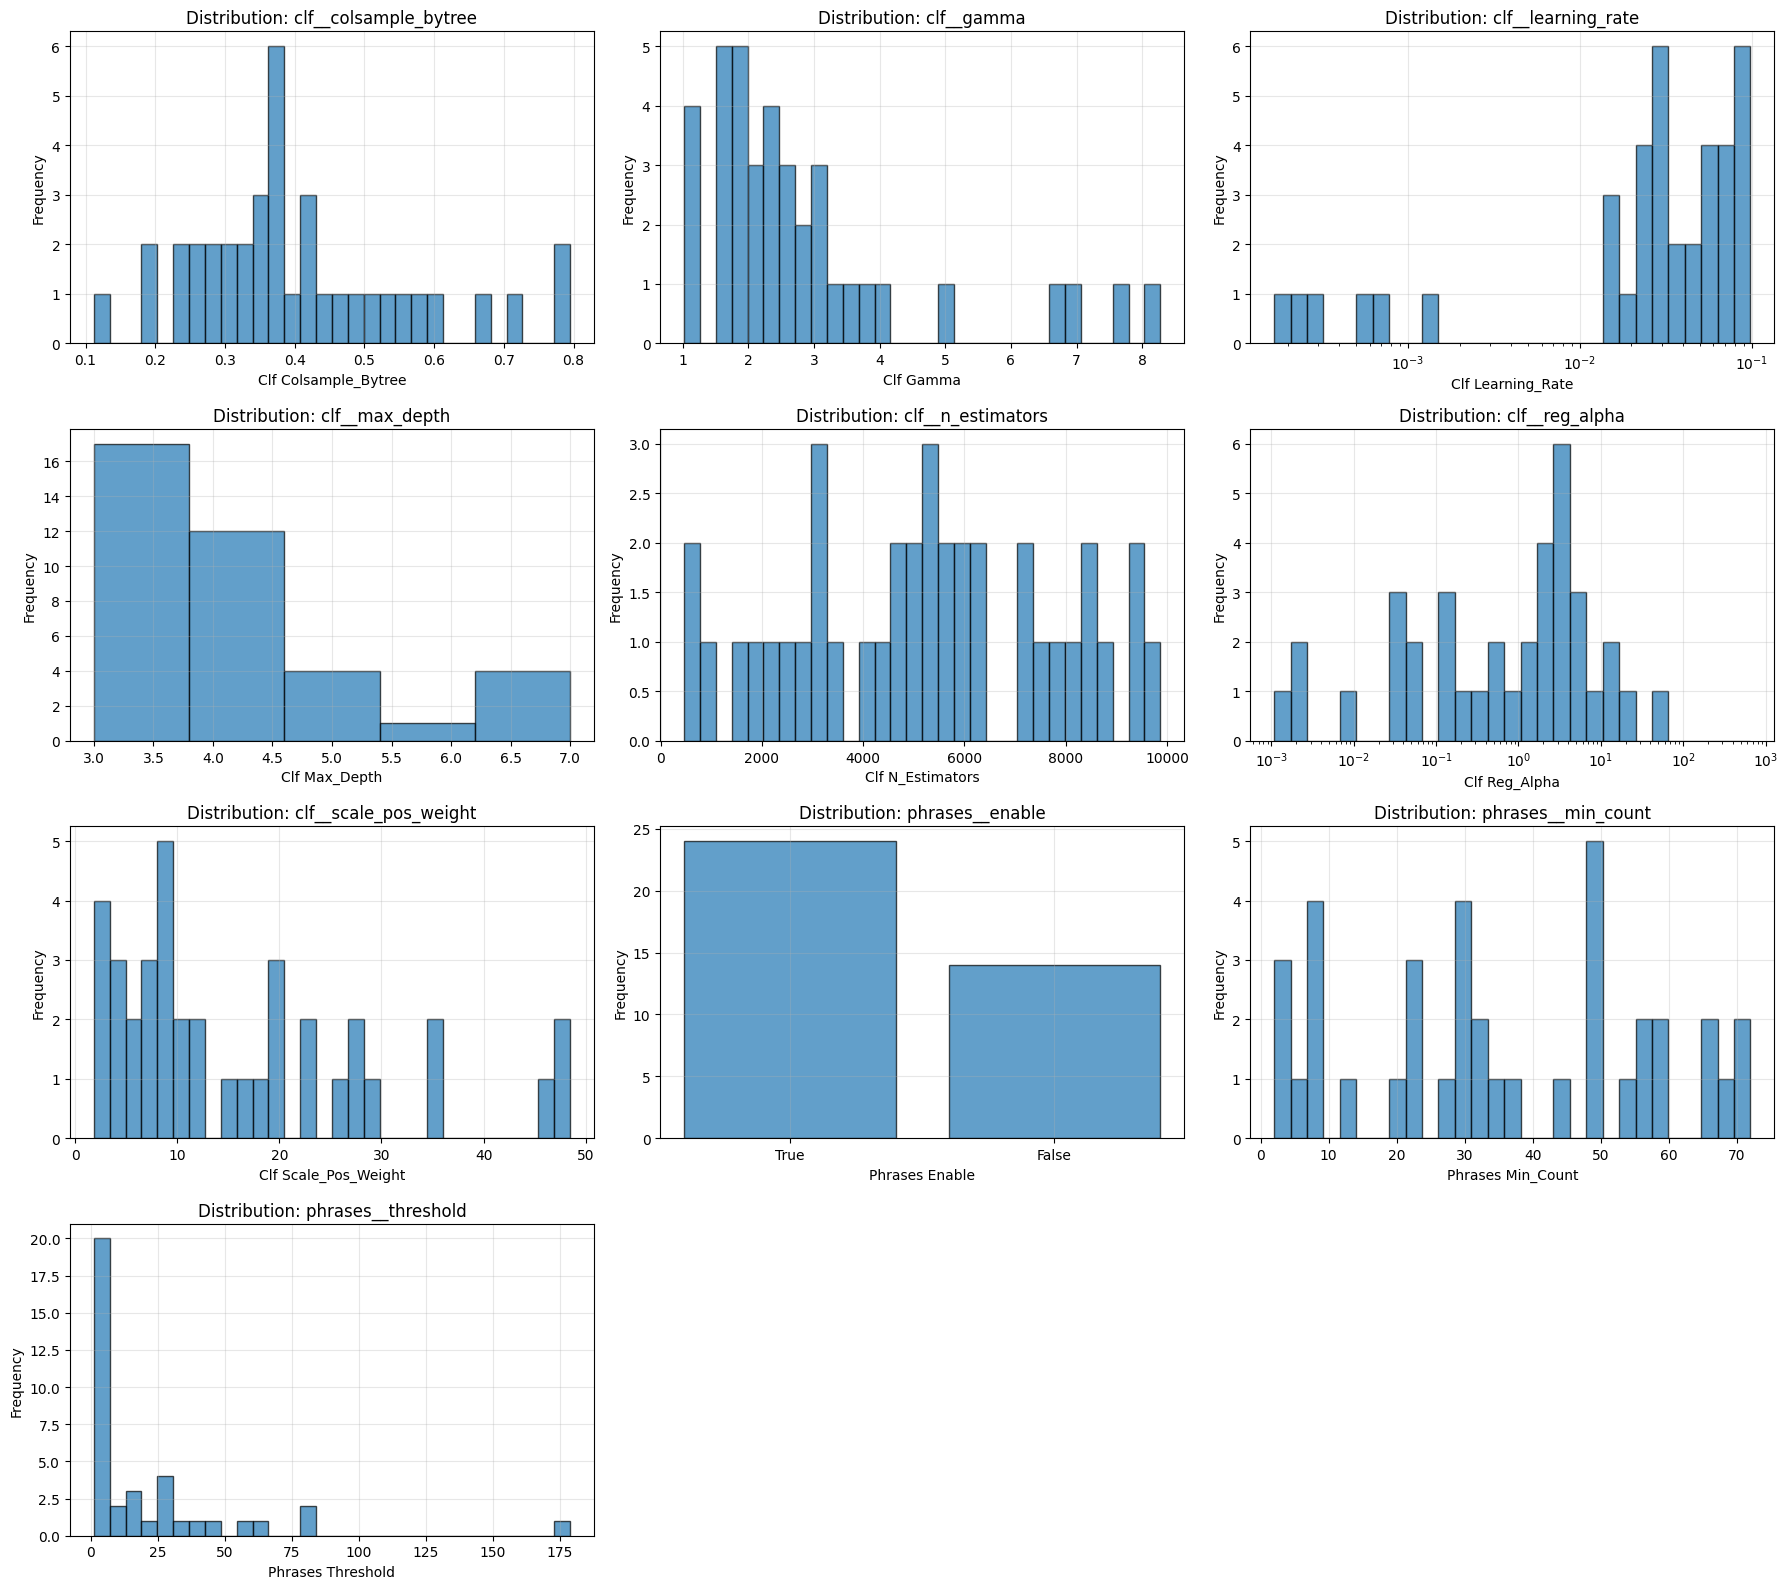


3. Performance vs Individual Parameters:


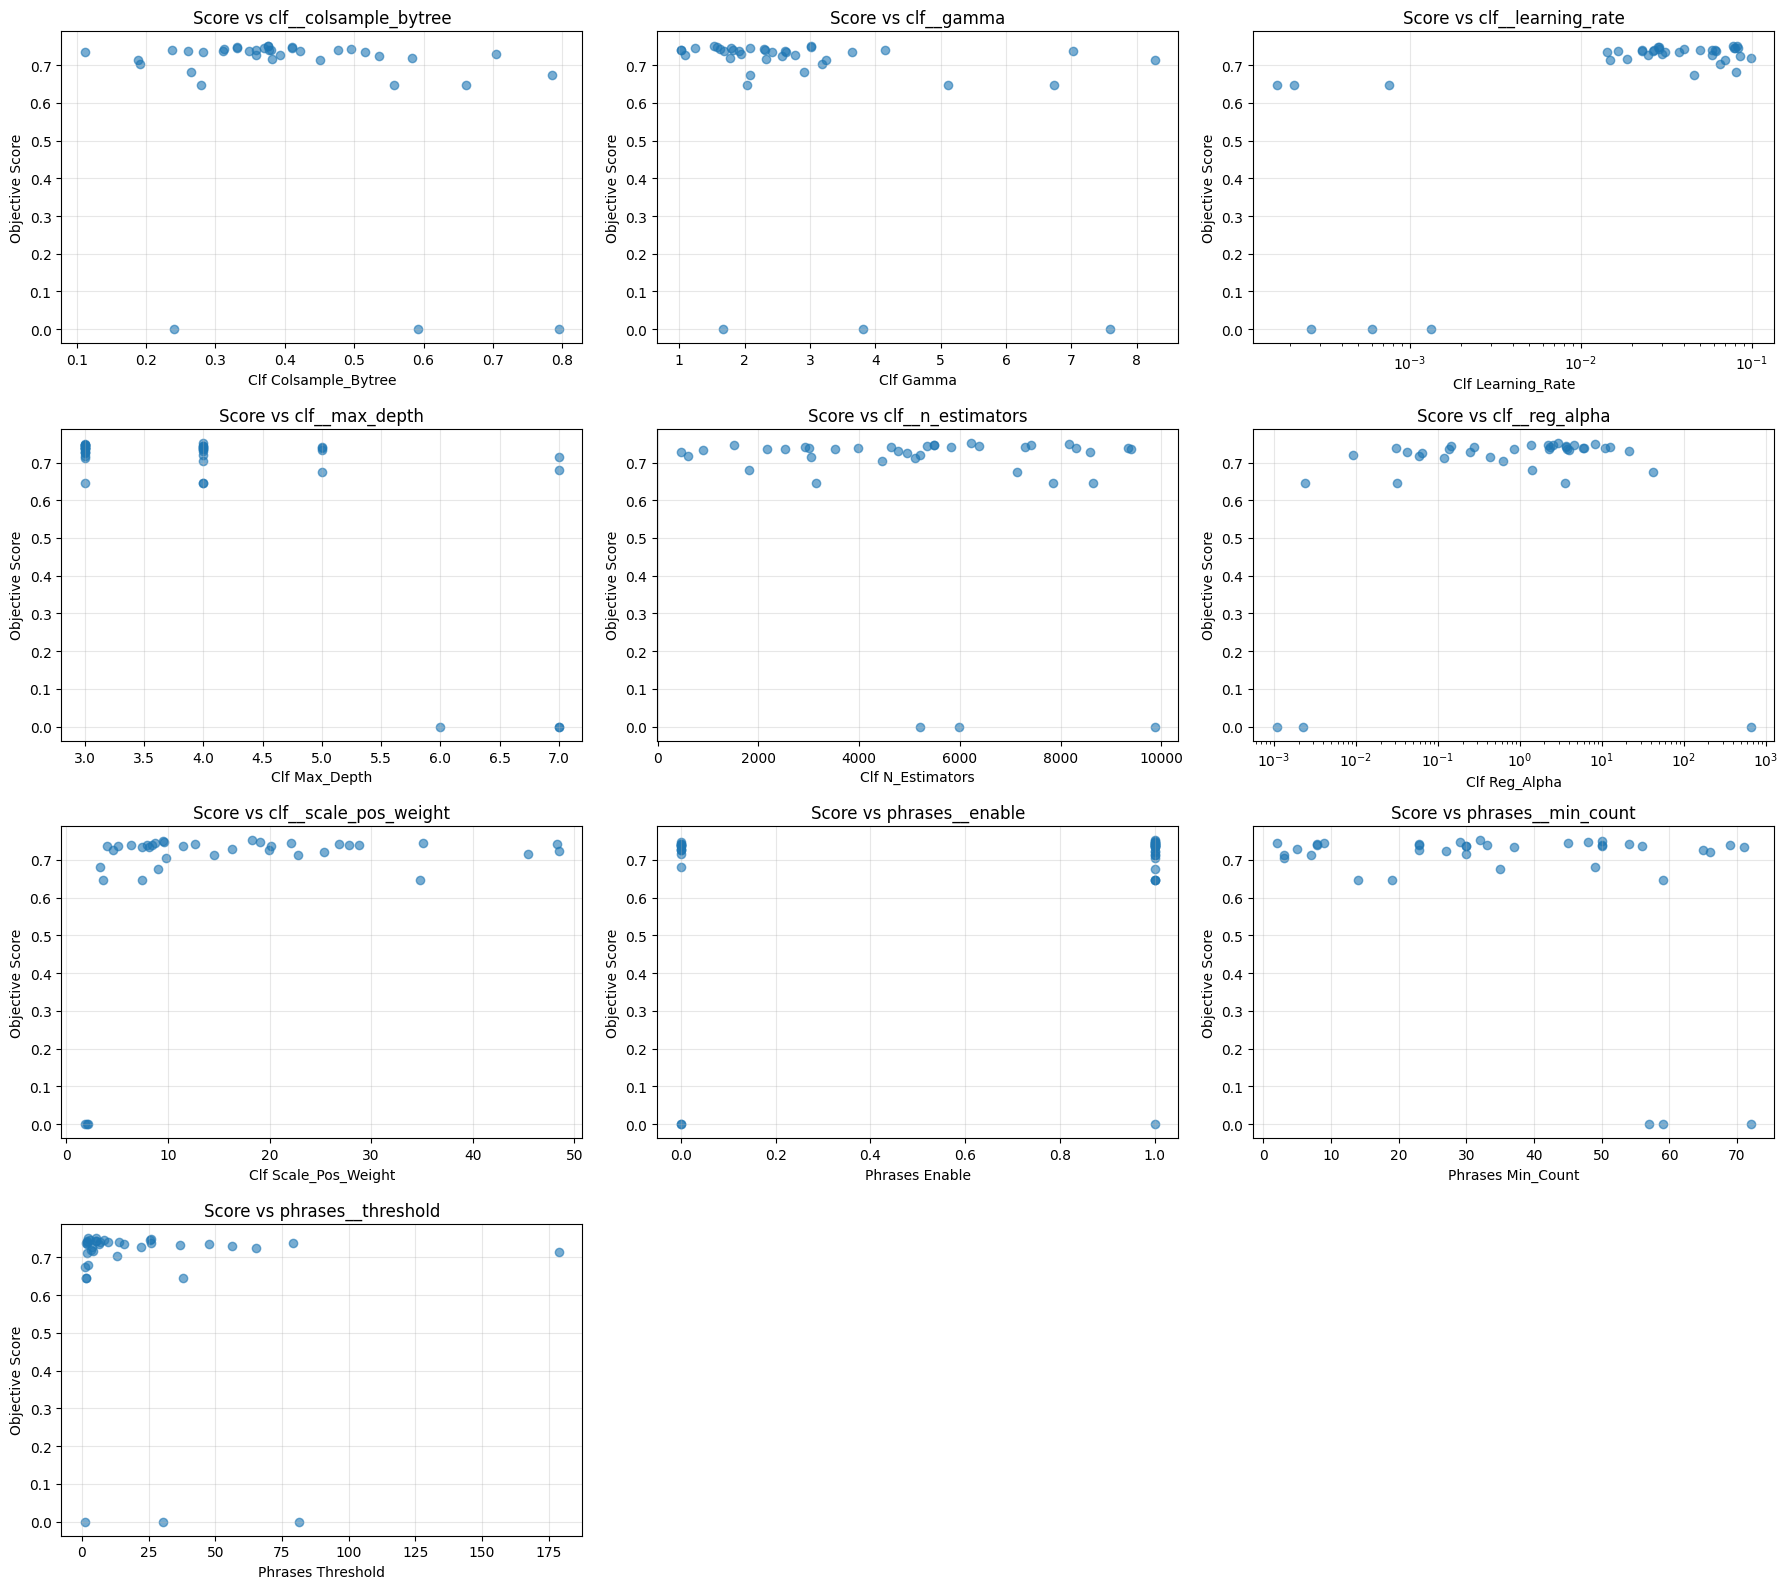


4. Convergence Analysis:


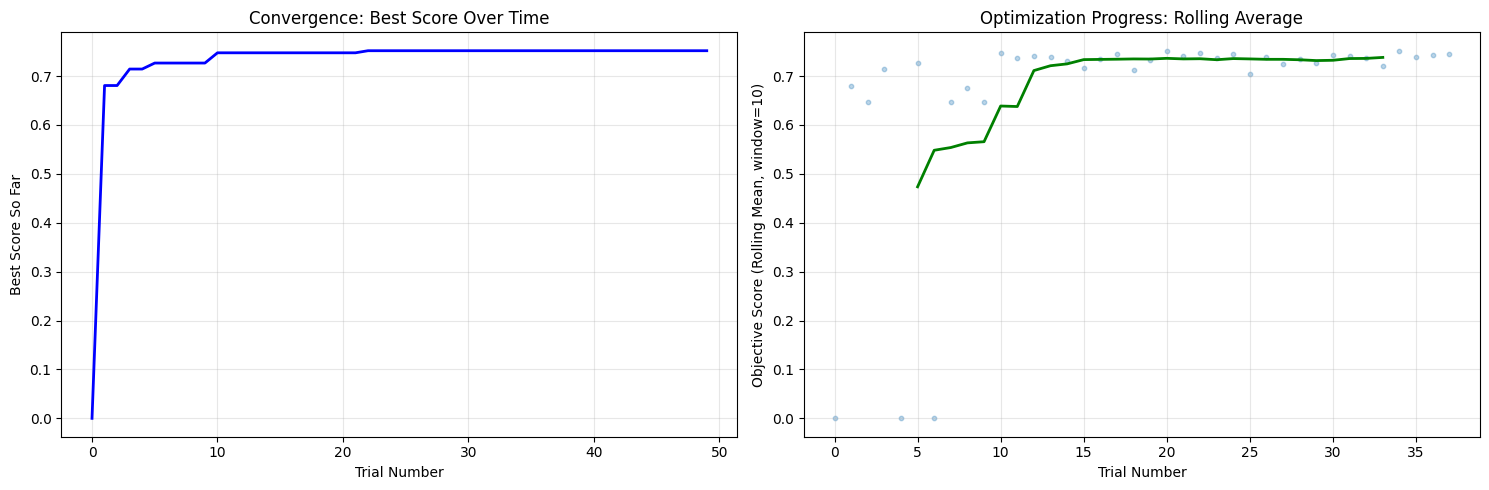


5. Trial Status Overview:


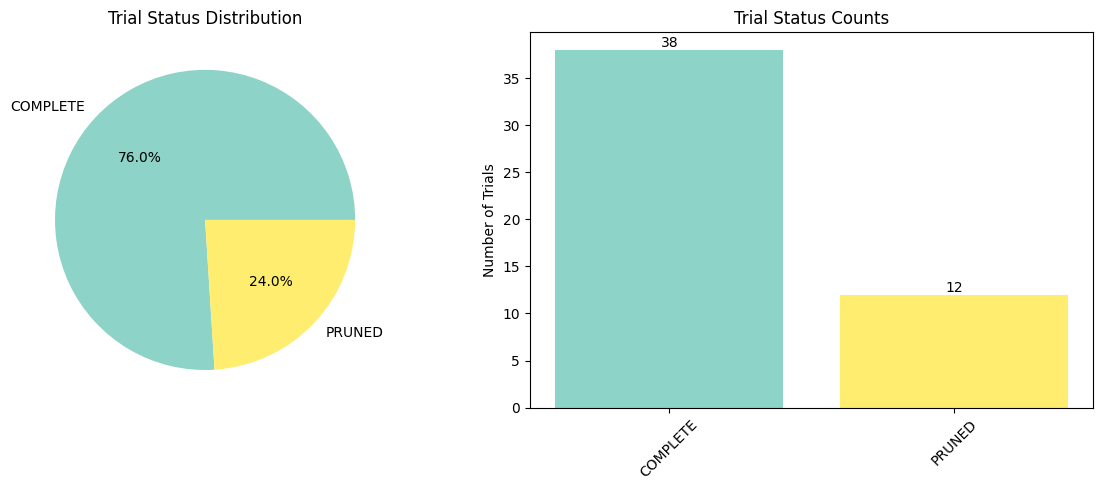


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight enable       min_count    threshold   
------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    22      0.7519     0.3752       1.5241       0.0776       4            6220         2.9571       18.2966      True         32           5.1712      
2    44      0.7503     0.3761       3.0146       0.0817       3            8170         8.2258       9.5044       True         50           2.1694      
3    10      0.7476     0.4100       3.0117       0.0287       3            1510         1.3602       19.0524      False        29           25.7885     
4    24      0.7467     0.3314       1.5816       0.0282       3            7410         4.6234       9.6225       True         48           3.0838      
5    18      0.7453     0.3305    

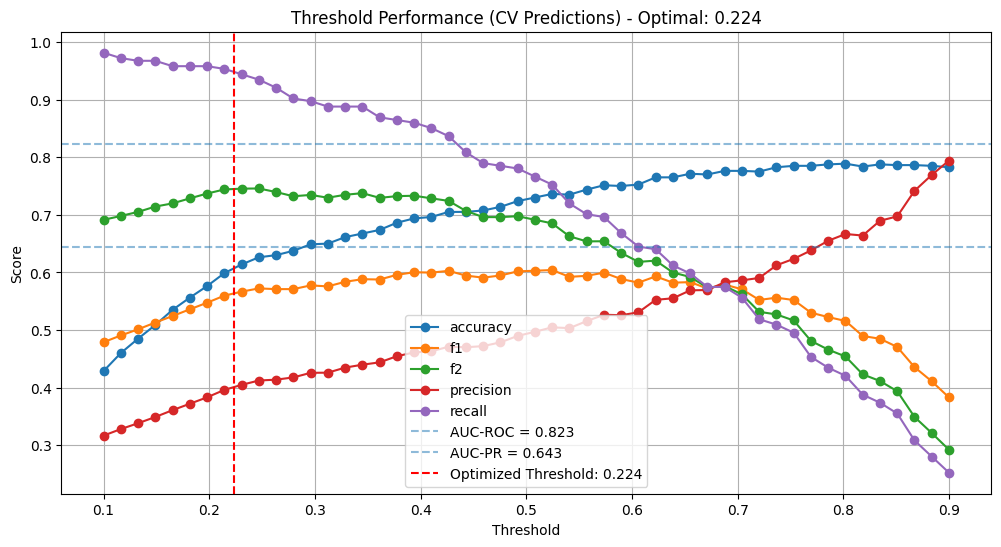

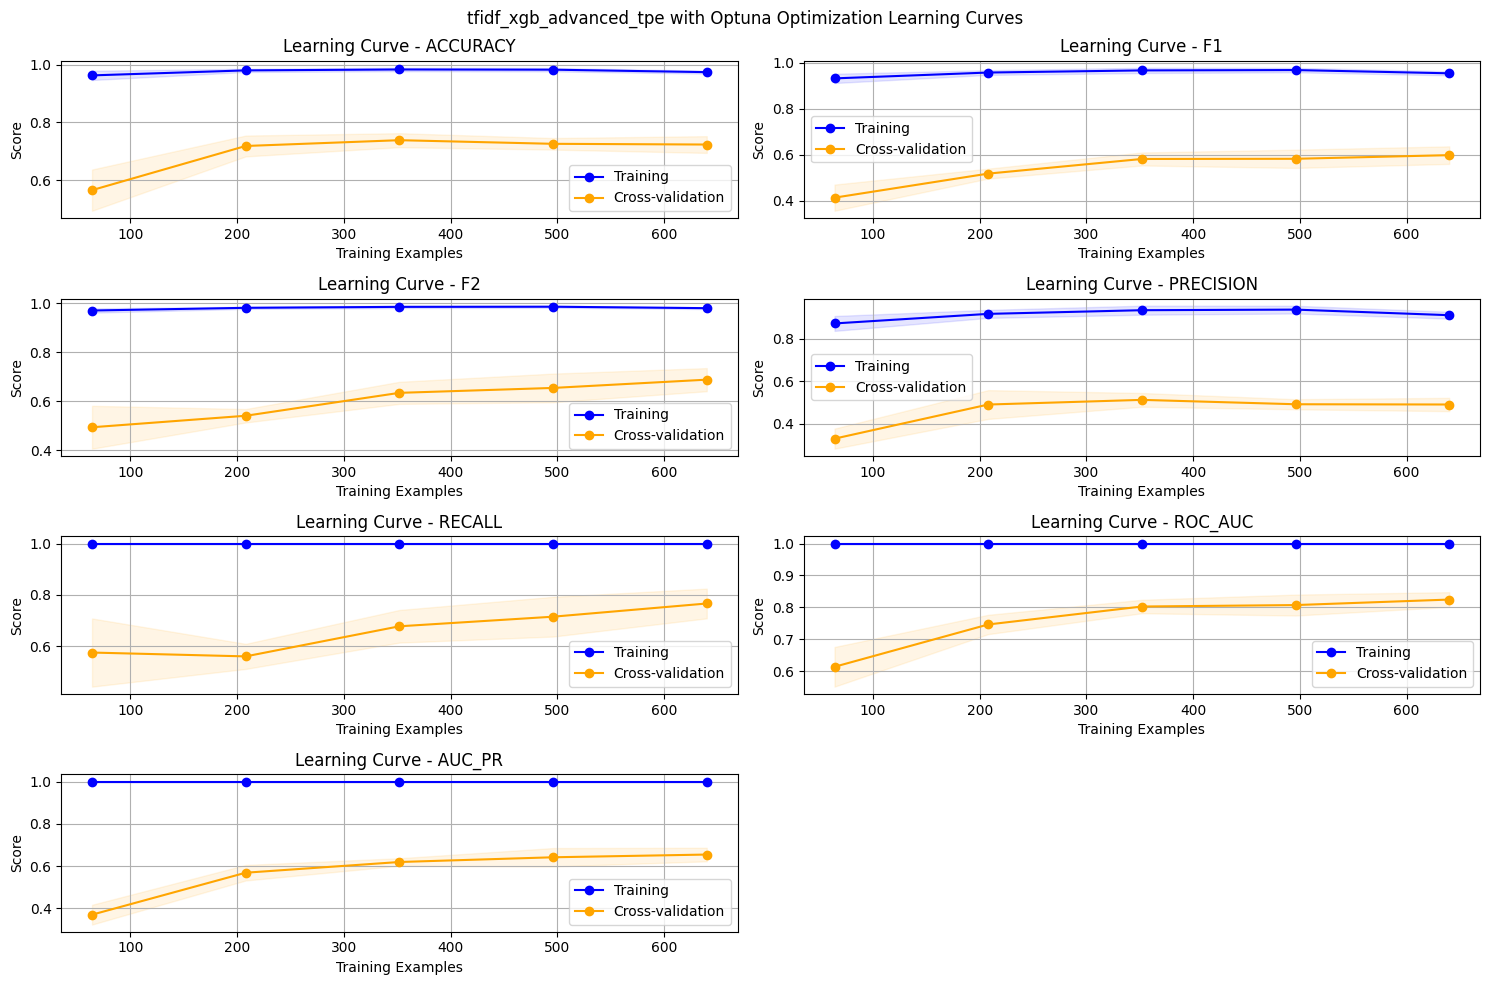


Final Threshold: 0.22

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.47      0.62       146
           1       0.39      0.91      0.54        54

    accuracy                           0.58       200
   macro avg       0.66      0.69      0.58       200
weighted avg       0.78      0.58      0.60       200

Additional Metrics:
Accuracy   0.585
F2-score   0.714
AUC-ROC    0.803
AUC-PR     0.645



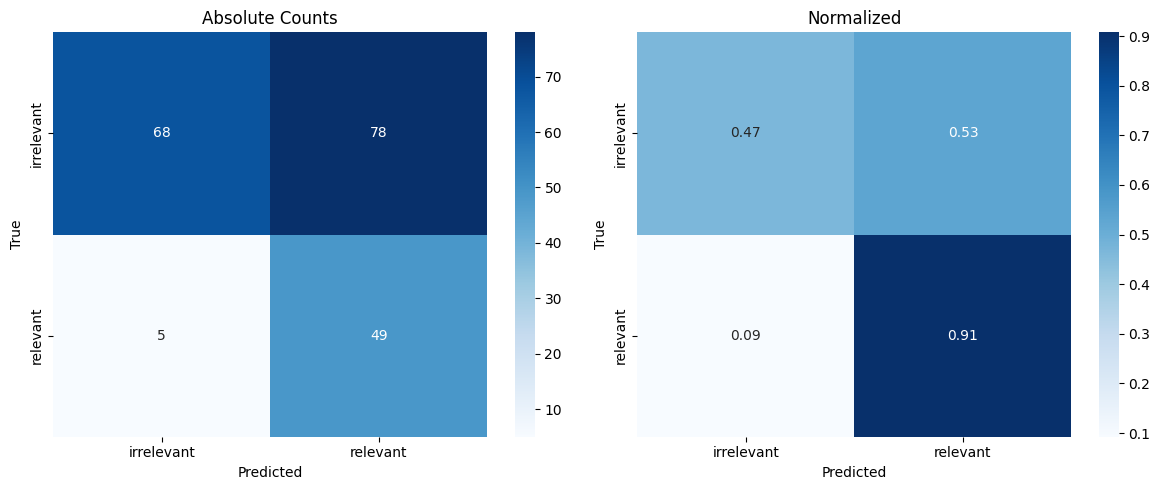

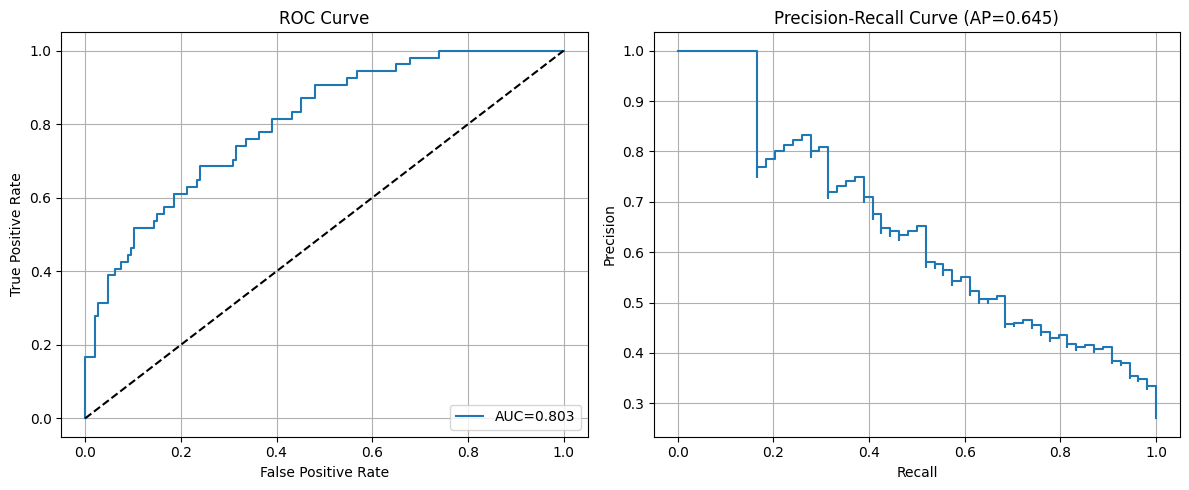


Model saved as model_tfidf_xgb_advanced_tpe.joblib


In [8]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline with fastText vectorization
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")
pipeline_fasttext_xgb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__learning_rate":    lambda t: t.suggest_float("clf__learning_rate", 1e-4, 1e-1, log=True),   #  Reusens et al. ranges; log-scale matches multiplicative sensitivity of LR
    "clf__max_depth":        lambda t: t.suggest_int("clf__max_depth", 3, 7),                         #  Reusens et al.: shallow trees fit high-dim sparse TF-IDF features
    "clf__gamma":            lambda t: t.suggest_float("clf__gamma", 1.0, 10.0),                      #  Reusens et al.: minimum loss reduction to make a split (regularizes splits)
    "clf__n_estimators":     lambda t: t.suggest_int("clf__n_estimators", 10, 10000, step=10),        #  Reusens et al.: upper bound; Early Stopping in  objective picks best iteration
    "clf__colsample_bytree": lambda t: t.suggest_float("clf__colsample_bytree", 0.1, 1.0),            #  Reusens et al.: feature subsampling per tree; helps generalization with many sparse features
    "clf__scale_pos_weight": lambda t: t.suggest_float("clf__scale_pos_weight", 1.0, 50.0, log=True), #  XGBoost-native class balancing; typical anchor is sum(neg)/sum(pos). Search narrowly (±~3x, log) around data-driven ratio.
    "clf__reg_alpha":        lambda t: t.suggest_float("clf__reg_alpha", 1e-3, 1e+3, log=True),       # useful L1 on leaf weights: promotes conservatism/sparsity in tree outputs; kept narrow & log to avoid bloating search
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),        # 3 Parameters enabled in our advanced (multi word grouping) pipeline.
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "tfidf_xgb_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_fasttext_xgb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "xgboost",
    n_trials=50,  # Intelligent search with early stopping
    n_startup_trials=10,
    n_warmup_steps=1, #first trial not pruned
    intervall_steps=1, #pruning possible for every trial
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)

plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

XGB GridSearch advanced

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__scale_pos_weight': 25.0, 'clf__colsample_bytree': 0.3, 'clf__n_estimators': 7000, 'clf__learning_rate': 0.078, 'clf__max_depth': 4, 'clf__gamma': 1.5, 'clf__reg_alpha': 3.0, 'phrases__enable': True, 'phrases__min_count': 32, 'phrases__threshold': 5.0}
Best F2 score during optimization: 0.711

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


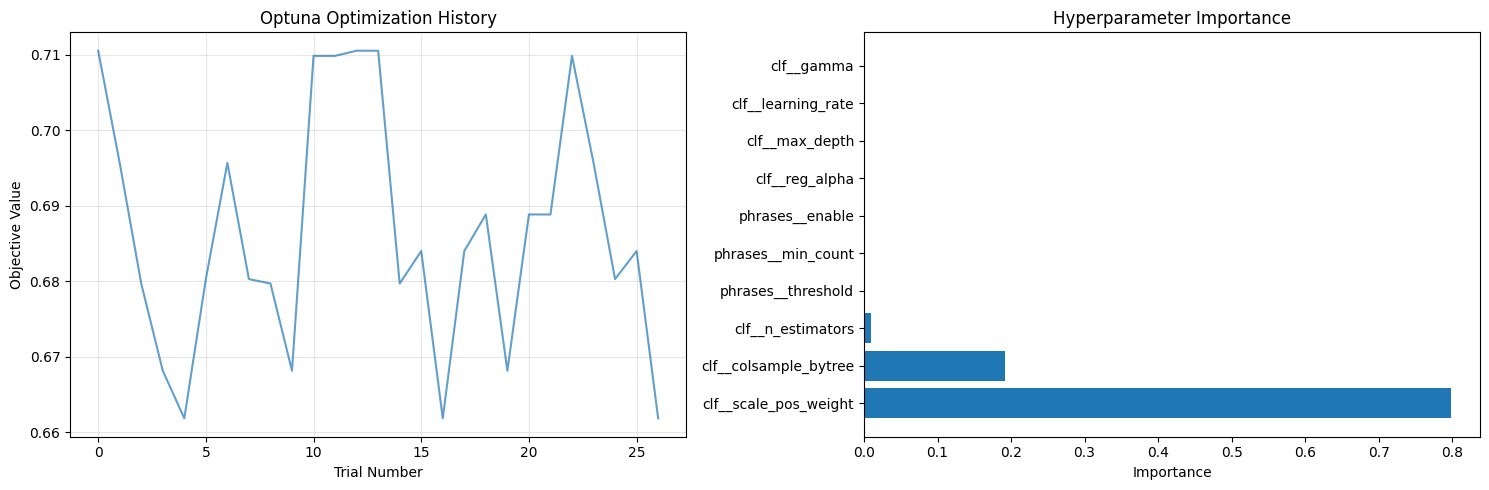


2. Parameter Value Distributions:


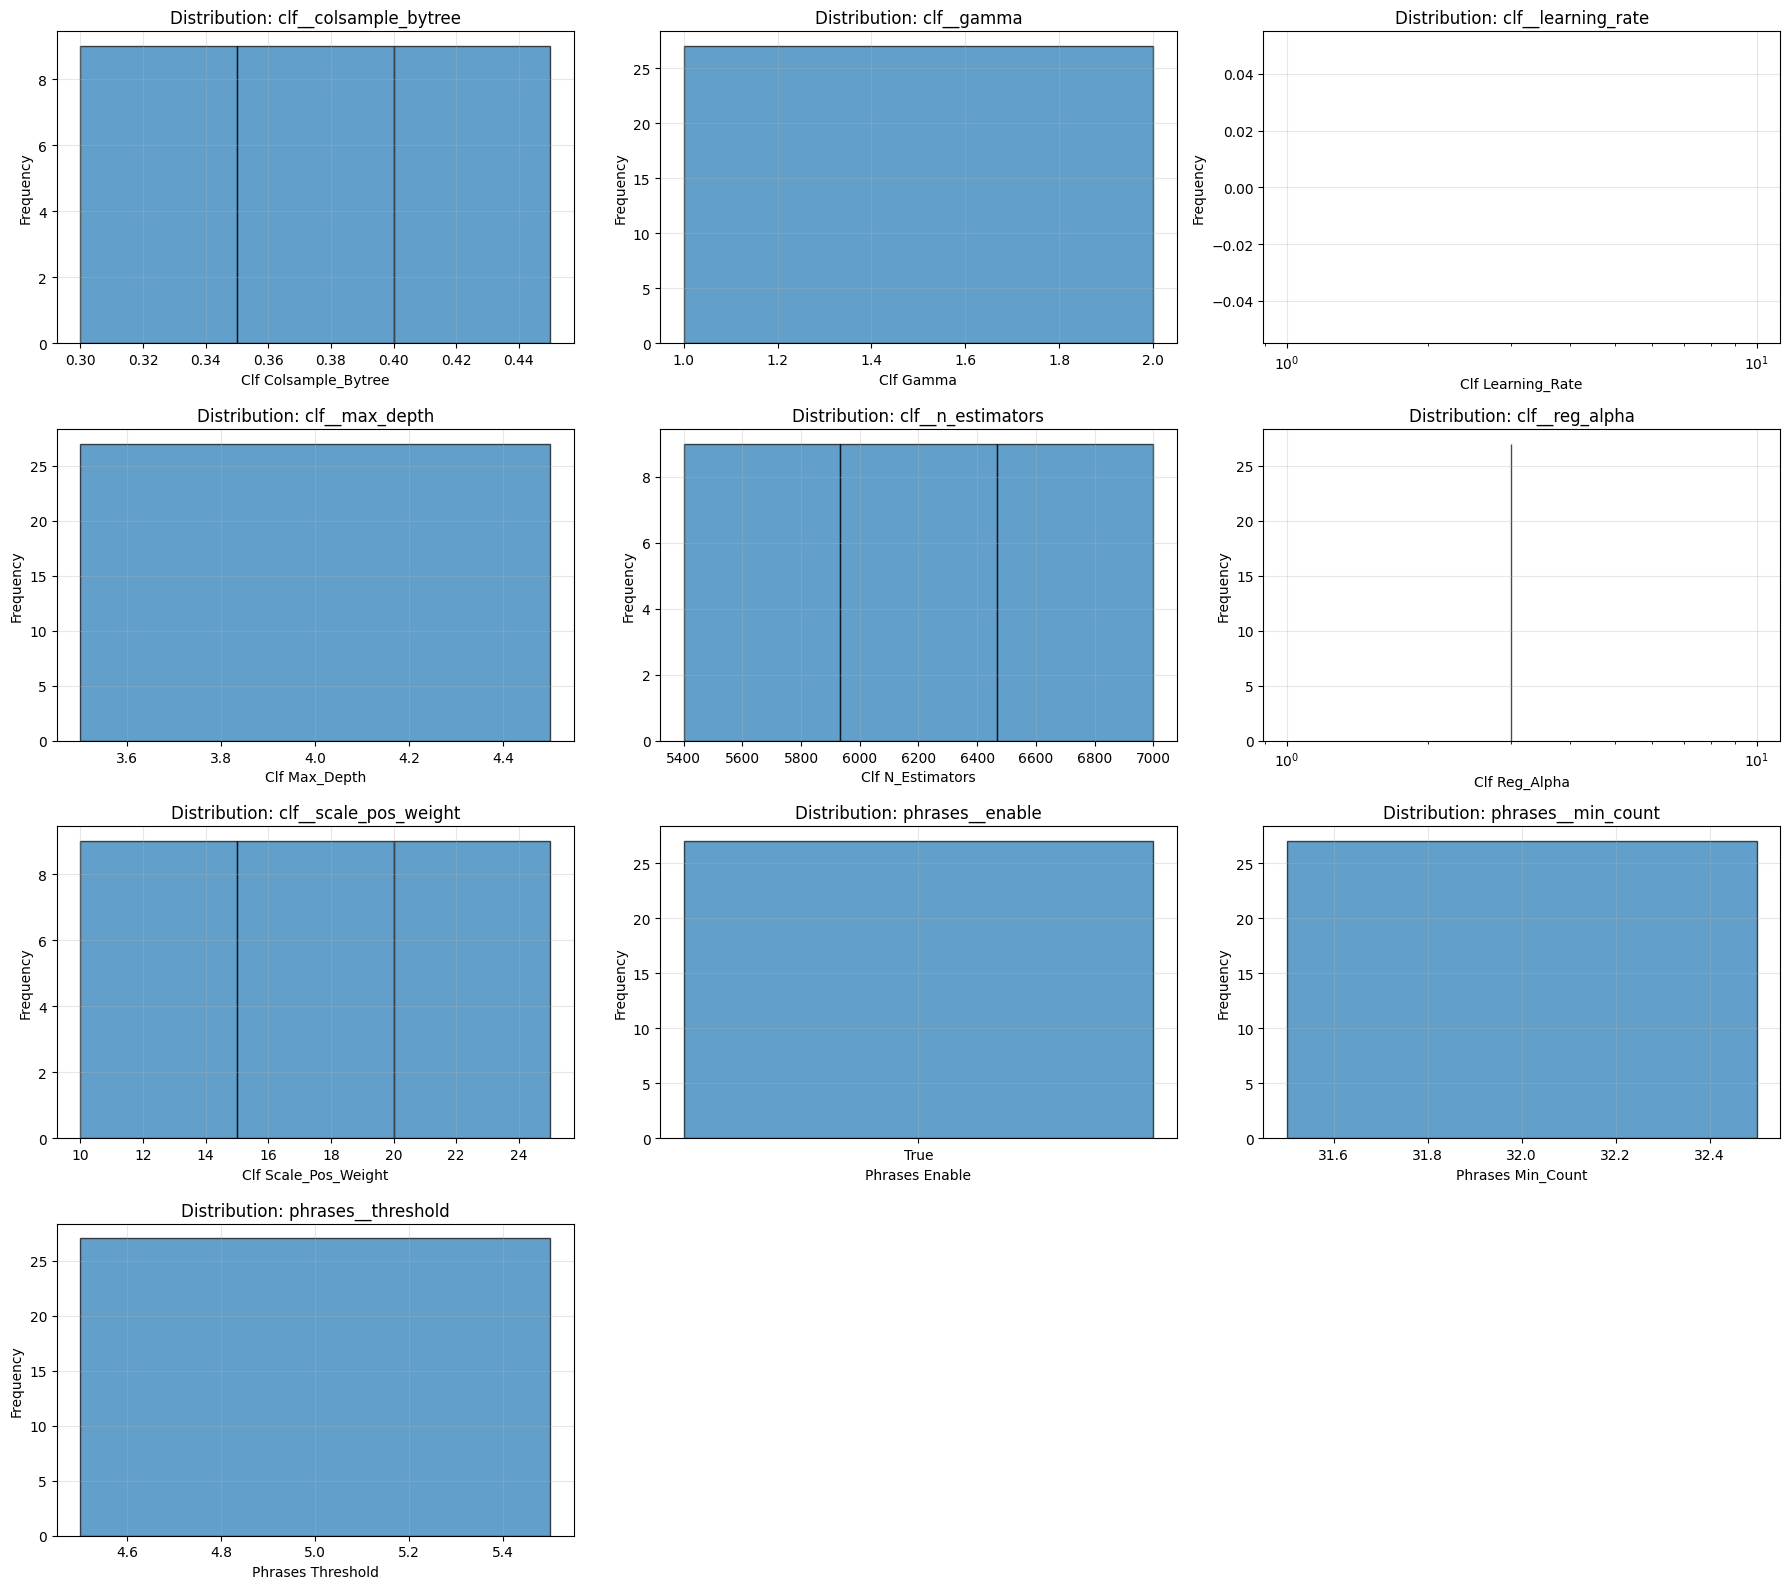


3. Performance vs Individual Parameters:


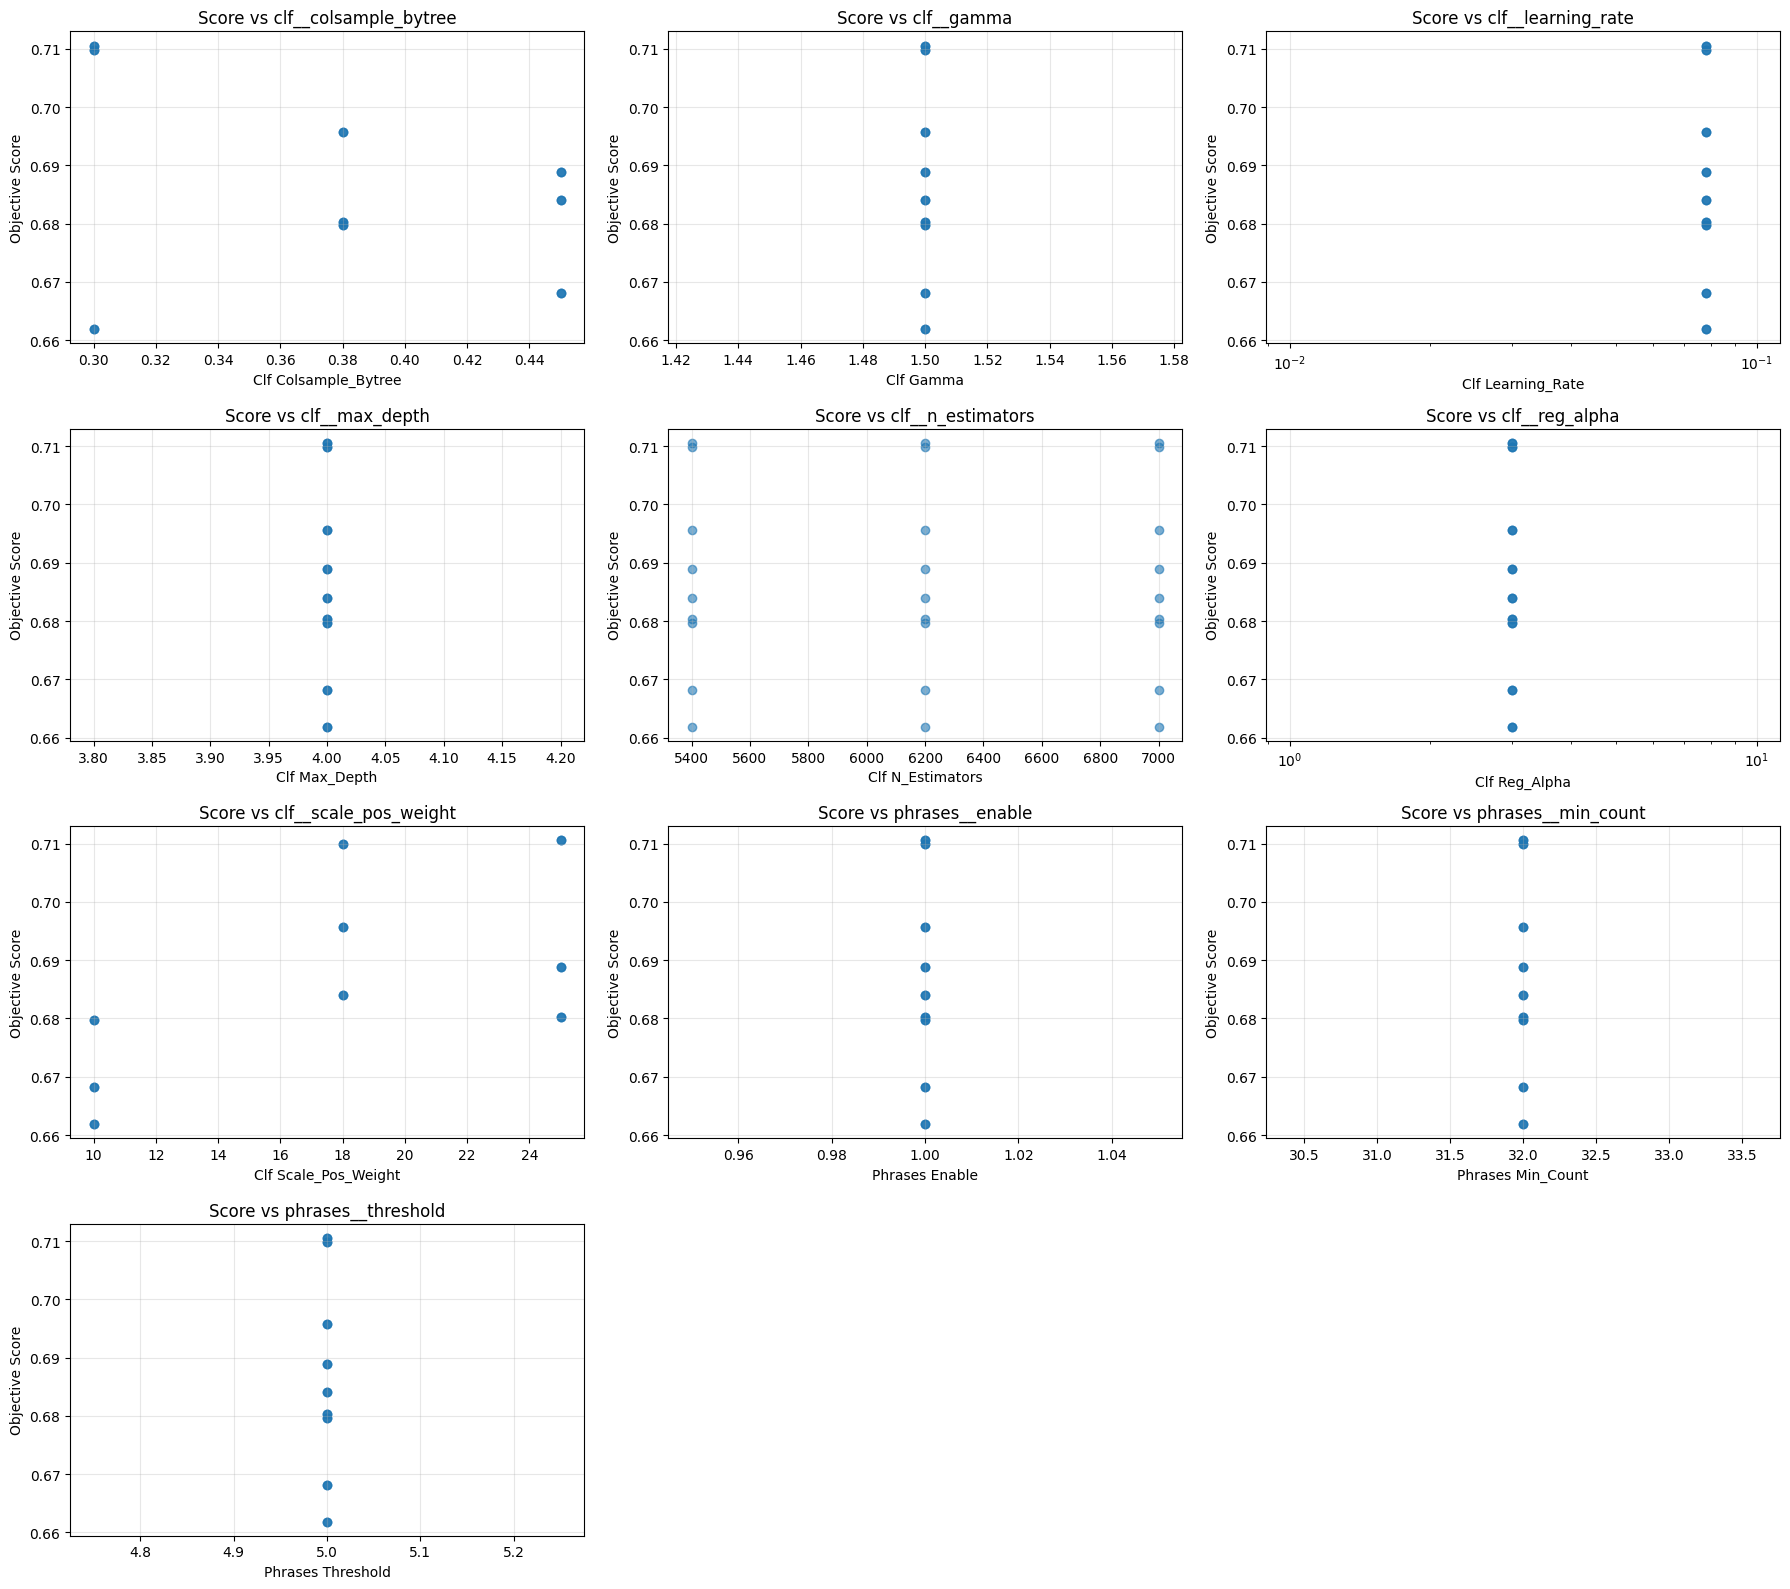


4. Convergence Analysis:


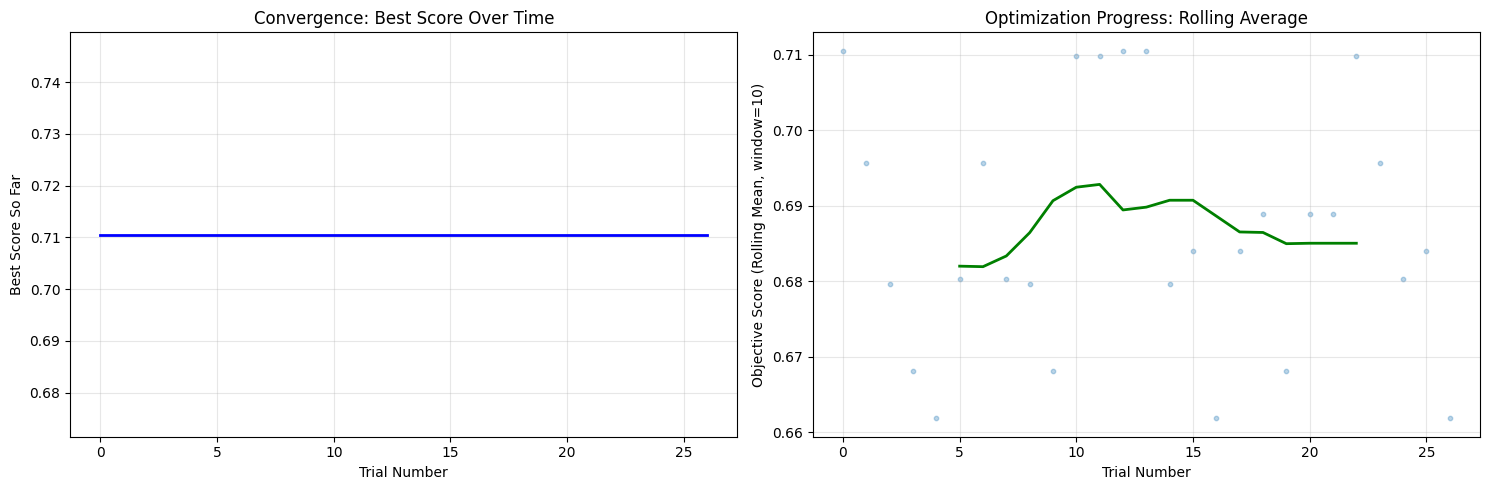


5. Trial Status Overview:


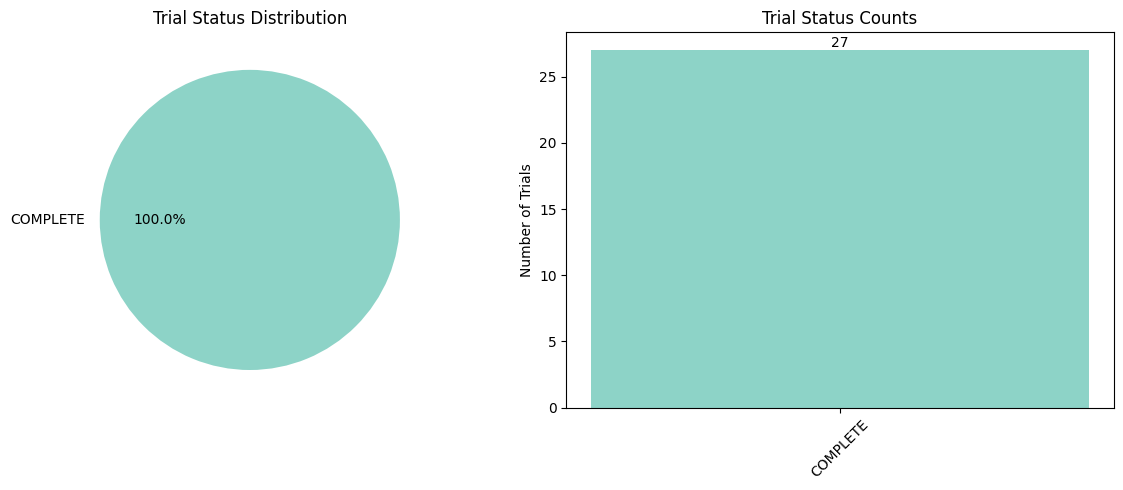


6. Top 10 Best Trials:
Rank Trial#  Score      colsample_bytree gamma        learning_rate max_depth    n_estimators reg_alpha    scale_pos_weight enable       min_count    threshold   
------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    0       0.7106     0.3000       1.5000       0.0780       4            7000         3.0000       25.0000      True         32           5.0000      
2    12      0.7106     0.3000       1.5000       0.0780       4            6200         3.0000       25.0000      True         32           5.0000      
3    13      0.7106     0.3000       1.5000       0.0780       4            5400         3.0000       25.0000      True         32           5.0000      
4    10      0.7099     0.3000       1.5000       0.0780       4            5400         3.0000       18.0000      True         32           5.0000      
5    11      0.7099     0.3000    

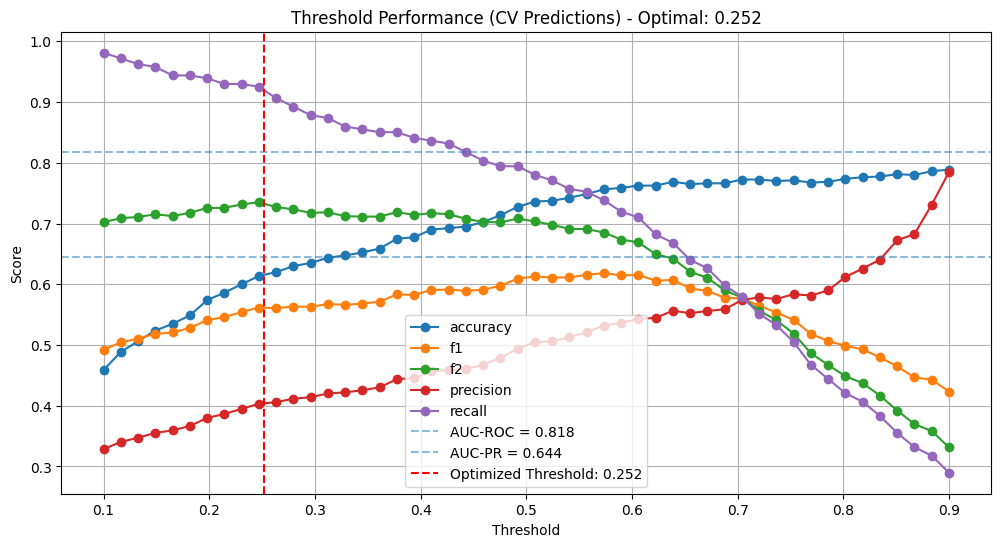

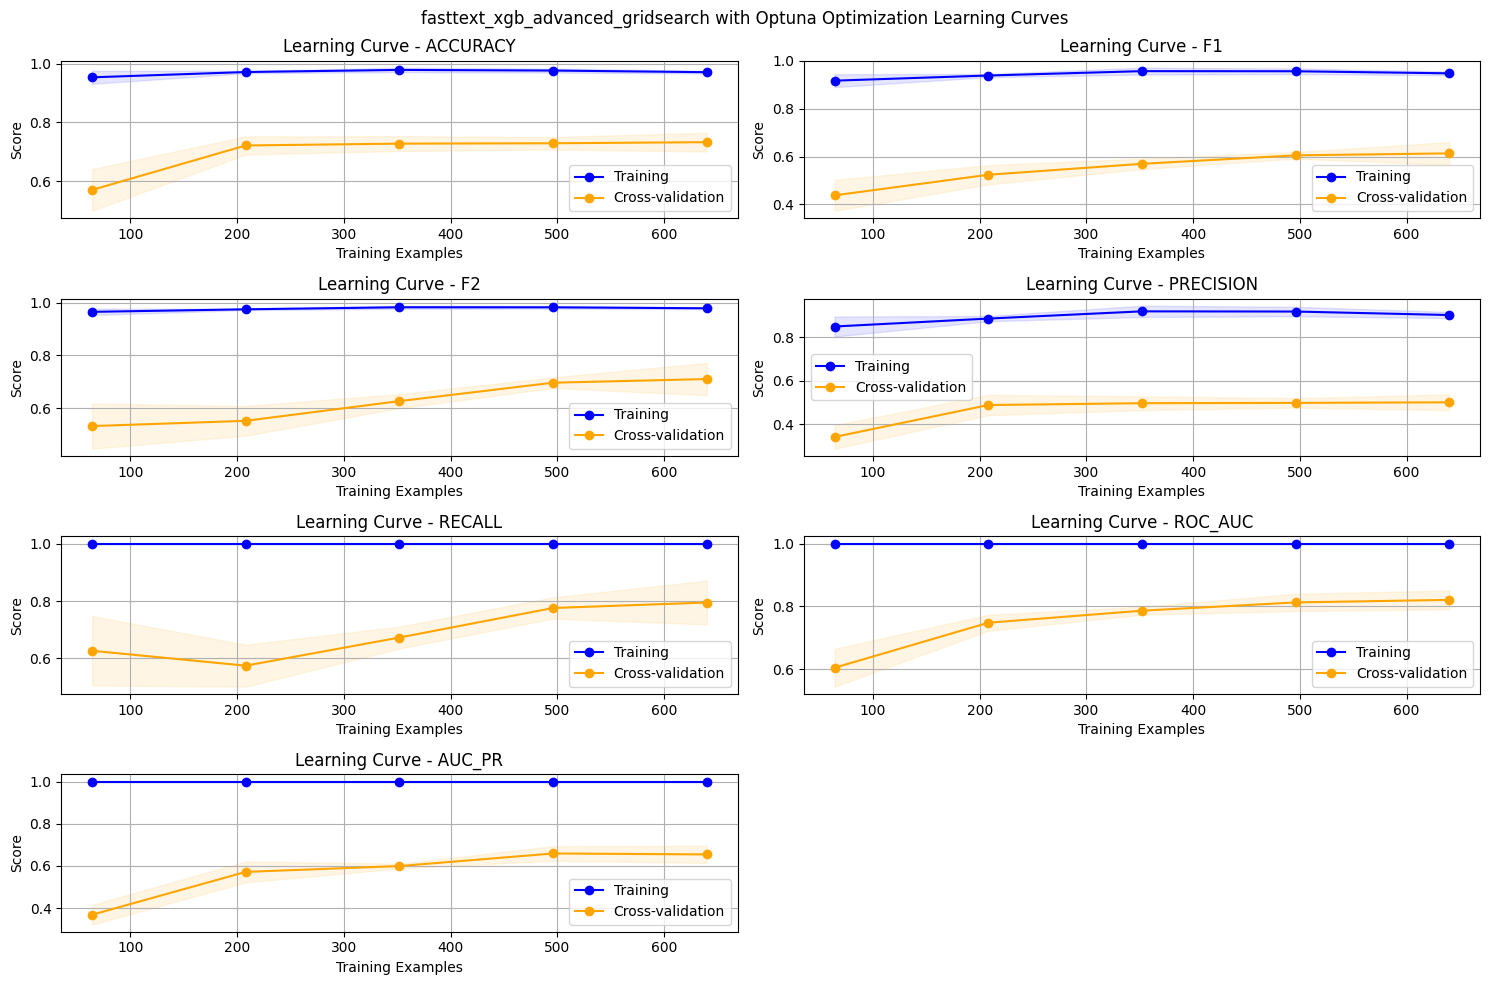


Final Threshold: 0.25

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.43      0.59       146
           1       0.38      0.94      0.54        54

    accuracy                           0.57       200
   macro avg       0.67      0.69      0.57       200
weighted avg       0.80      0.57      0.58       200

Additional Metrics:
Accuracy   0.570
F2-score   0.729
AUC-ROC    0.793
AUC-PR     0.628



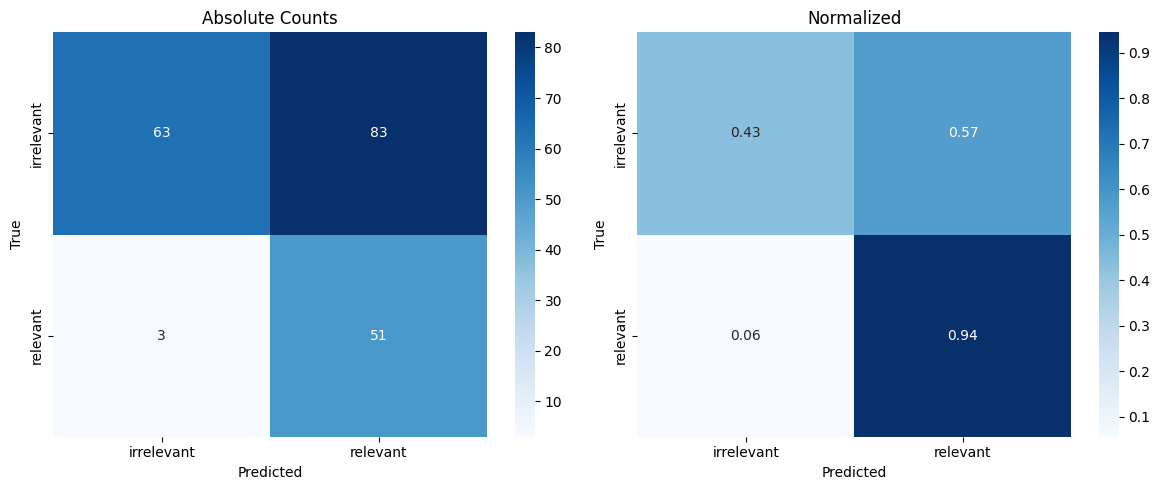

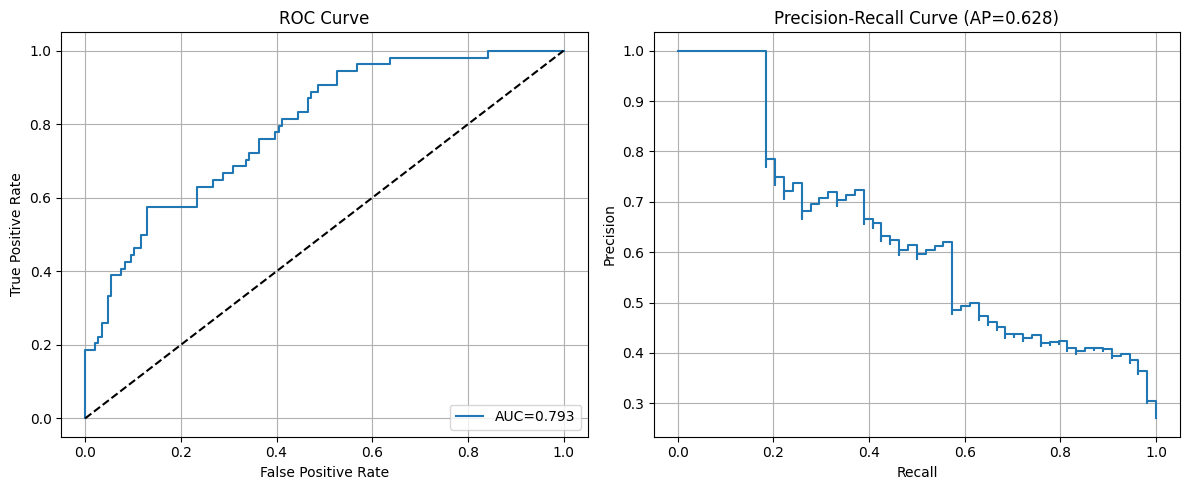


Model saved as model_fasttext_xgb_advanced_gridsearch.joblib


In [9]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline with fastText vectorization
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")
pipeline_fasttext_xgb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("embed", FastTextVectorizer(
        lang='de',
        model_dir=f'{root_path}/src/fasttext_embeddings',
        cache_key=ft_bin,
        mode='pool',
        pool='tfidf',
        debug=False
    )),
    ("clf",     XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                n_jobs=-1,  # Use all available CPU cores
                random_state=42,                  
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter grid for gridsearch
param_grid = {
    # Focus on the top 3 impactful parameters
    "clf__scale_pos_weight": [10.0, 18.0, 25.0],   # best ~18 → vary around it
    "clf__colsample_bytree": [0.30, 0.38, 0.45],   # best ~0.375 → scouts around
    "clf__n_estimators": [5400, 6200, 7000],       # best ~6220 → ± ~800

    # Fix all other params at Optuna-best
    "clf__learning_rate": [0.078],
    "clf__max_depth": [4],
    "clf__gamma": [1.5],
    "clf__reg_alpha": [3.0],
    "phrases__enable": [True],
    "phrases__min_count": [32],
    "phrases__threshold": [5.0],
}


model_name = "fasttext_xgb_advanced_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_fasttext_xgb,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")